In [6]:
# Paths
import os
import warnings
import sys
if not sys.warnoptions:
    warnings.simplefilter("ignore")
    os.environ["PYTHONWARNINGS"] = ('ignore::UserWarning,ignore::ConvergenceWarning,ignore::RuntimeWarning')

os.chdir('../..')
from pcmf import pcmf_full, path_plot, plot_ordercolor, plot_cluster_assignments, PCMF_predict_clusters
from p3ca import cluster_metrics, calculate_scores_nonpath
import numpy as np
%load_ext autoreload


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
# Functions
def run_fitPCMF_experiment_consensusICML2023(savedir='/Users/amandabuch/Documents/clusterCCA/PCMF/results_ICML2023/',dataset='MNIST', problem_rank=100, rho=2.0, gc=1.0, neighbors=40, admm_iters=2, penalty_list = np.concatenate((np.repeat(np.inf,5),np.exp(np.linspace(-50,10,10))[::-1]),axis=0), skip=1, labels_keep=[0,1,2,3,4,5], data_path='/Users/amandabuch/Documents/clusterCCA/revision1/clusterCCA/data/',randomize=False):
    from pcmf import pcmf_full_consensus_2023 as pcmf_consensus
    import time
    from sklearn.preprocessing import Normalizer, StandardScaler, MinMaxScaler
    # LOAD DATA
    batch_size = 50
    if dataset == 'MNIST':
        save_path=savedir+'MNIST_'+'skip'+str(skip)+'_nclusters'+str(len(labels_keep))+'_batchSize_'+str(batch_size)+'_pathLength'+str(len(penalty_list))+'problem_rank'+str(problem_rank)+'_gausscoef'+str(gc)+'_neighbors'+str(neighbors)+'_admm_iters'+str(admm_iters)+'_rho'+str(rho)+'_randomize'+str(randomize)
        X_in, true_clusters_in, X_in_test, true_clusters_in_test, true_clusters_labels, num_clusters = load_MNIST(labels_keep=[0,1,2,3,4,5], plot=False, skip=skip, batch_size=batch_size, randomize=randomize)
        u_true = []
        v_true = []
    elif dataset == 'FashionMNIST':
        save_path=savedir+'FashionMNIST_'+'skip'+str(skip)+'_nclusters'+str(len(labels_keep))+'_batchSize_'+str(batch_size)+'_pathLength'+str(len(penalty_list))+'problem_rank'+str(problem_rank)+'_gausscoef'+str(gc)+'_neighbors'+str(neighbors)+'_admm_iters'+str(admm_iters)+'_rho'+str(rho)+'_randomize'+str(randomize)
        X_in, true_clusters_in, X_in_test, true_clusters_in_test, true_clusters_labels, num_clusters = load_FashionMNIST(labels_keep=[0,1,2,3,4,5], plot=False, skip=skip, batch_size=batch_size, randomize=randomize)
        u_true = []
        v_true = []
    elif dataset == 'GBMBreastLung':
        save_path=savedir+'GBMBreastLung_'+'skip'+str(skip)+'_batchSize_'+str(batch_size)+'_pathLength'+str(len(penalty_list))+'problem_rank'+str(problem_rank)+'_gausscoef'+str(gc)+'_neighbors'+str(neighbors)+'_admm_iters'+str(admm_iters)+'_rho'+str(rho)+'_randomize'+str(randomize)
        X_in, true_clusters_in, X_in_test, true_clusters_in_test, true_clusters_labels, num_clusters  = load_GBMBreastLung(data_path=data_path, plot=False, skip=skip, batch_size=batch_size, randomize=randomize)
        u_true = []
        v_true = []
    elif dataset == 'Synthetic':
        save_path=savedir+'Synthetic100000_'+'_batchSize_'+str(batch_size)+'_pathLength'+str(len(penalty_list))+'problem_rank'+str(problem_rank)+'_gausscoef'+str(gc)+'_neighbors'+str(neighbors)+'_admm_iters'+str(admm_iters)+'_rho'+str(rho)+'_randomize'+str(randomize)
        X_in, true_clusters_in, X_in_test, true_clusters_in_test, num_clusters, u_true, v_true = load_syntheticDataConsensus(n=100000, n_test=10000, p=1000, m=25000, m_test=2500, plot=False, randomize=randomize)
    else:
        print('Dataset not implemented:',dataset)
        return
    
    print('Problem rank',problem_rank)
    print('Save path is:',save_path+'.npz')

    # STANDARDIZE DATA
    scaler = StandardScaler(with_mean=True,with_std=False).fit(X_in)
    X_in = scaler.transform(X_in)
    normalizer = Normalizer().fit(X_in)
    X_in = normalizer.transform(X_in)
    scaler2 = StandardScaler(with_mean=False,with_std=True).fit(X_in)
    X_in = scaler2.transform(X_in)

    X_in_test = scaler.transform(X_in_test)
    X_in_test = normalizer.transform(X_in_test)
    X_in_test = scaler2.transform(X_in_test)

    # Fit PCMF
    tic=time.time()
    A_list, U_list, s_list, V_list = pcmf_consensus(X_in, penalty_list, split_size=batch_size, problem_rank=np.min((problem_rank,X_in.shape[1])), rho=rho, gauss_coef=gc, weights='Gaussian', admm_iters = admm_iters, neighbors=neighbors)
    toc=time.time() - tic
    
    A = A_list
    U = U_list
    S = s_list
    V = V_list

    X_compA = []
    X_compB = []
    UV = []
    USV = []
    for p in range(len(penalty_list)):
        x_pcmf = U[p]*S[p][:,0] # should the 0 be here??
        x_pcmf2 = (X_in[:,:] @ V[p].T) 
        X_compA.append(np.array(x_pcmf))
        X_compB.append(np.array(x_pcmf2))
        UV.append((np.array(U[p])[:,:]@np.array(V[p])[:,:]))
        USV.append((np.array(U[p])[:,:]*np.array(S[p]).flatten())@np.array(V[p])[:,:])

    X_compA=np.asarray(X_compA)
    X_compB=np.asarray(X_compB)
    
    # SAVE DATASET    
    np.savez(save_path+".npz",  A=A, U=U, S=S, V=V, UV=UV, USV=USV, X_compA=X_compA, X_compB=X_compB, X_in=X_in, true_clusters_in=true_clusters_in, X_in_test=X_in_test, true_clusters_in_test=true_clusters_in_test, true_clusters_labels=true_clusters_labels, num_clusters=num_clusters, u_true=u_true, v_true=v_true, split_size=batch_size, runtime=toc, penalty_list=np.asarray(penalty_list), rho=rho, admm_iters=admm_iters, gc=gc, neighbors=neighbors) 
#     generate_plots_synthetic(A, U, V, S, split_size, penalty_list, true_clusters_all, save_path+".pdf")
    del A, U, S, V, UV, USV, X_compA, X_compB, X_in, true_clusters_in, toc
    
    return save_path+".npz"


from sklearn.decomposition import PCA
from sklearn.cluster import SpectralClustering, KMeans, AgglomerativeClustering
from sklearn.neighbors import kneighbors_graph
from sklearn.metrics import confusion_matrix, accuracy_score
from scipy.optimize import linprog, linear_sum_assignment as linear_assignment

def confusion_matrix_ordered(pred, true):
    def _make_cost_m(cm):
        s = np.max(cm)
        return (- cm + s)
    conf_mat = confusion_matrix(pred,true)
    indexes = linear_assignment(_make_cost_m(conf_mat))
    js = [e for e in sorted(indexes, key=lambda x: x[0])[1]]
    conf_mat_ord = conf_mat[:, js]
    return conf_mat_ord

# Tumors
# Fashion MNIST
def load_GBMBreastLung(data_path='/Users/amandabuch/Documents/clusterCCA/revision1/clusterCCA/data/', plot=False, skip=1, batch_size=50, randomize=False):
    import numpy as np
    import os
    from keras.datasets import fashion_mnist
    from matplotlib import pyplot
    import pandas as pd

    print('Loading GBM Breast Lung')
    # Load GbmBreastLungCancer dataset
    gbm = pd.read_csv(os.path.join(data_path, 'gbm_z.txt'), sep='\t', header=0)
    lung = pd.read_csv(os.path.join(data_path, 'lung_z.txt'), sep='\t', header=0)
    breast = pd.read_csv(os.path.join(data_path, 'breast_z.txt'), sep='\t', header=0)
    labels = np.hstack((np.repeat('gbm',gbm.shape[0]),np.repeat('lung',lung.shape[0]),np.repeat('breast',breast.shape[0])))
    gbm_T = gbm.T
    gbm_T['variables'] = gbm.columns
    lung_T = lung.T
    lung_T['variables'] = lung.columns
    breast_T = breast.T
    breast_T['variables'] = breast.columns
    data_T = pd.merge(gbm_T,pd.merge(lung_T,breast_T,on='variables'),on='variables')
    data = data_T.drop(columns='variables').T
    data.columns = data_T['variables']
    
    train_X = data.to_numpy()[0:400,:]
    test_X = data.to_numpy()[400:data.shape[0],:]
    train_y = labels[0:400]
    test_y = labels[400:data.shape[0]]

    # Shape of dataset
    print('X_train: ' + str(train_X.shape))
    print('Y_train: ' + str(train_y.shape))
    print('X_test:  '  + str(test_X.shape))
    print('Y_test:  '  + str(test_y.shape))
    
    num_clusters = 3

    if plot is True:
        # Plotting
        from matplotlib import pyplot as plt
        # Set data generation parameters
        colors = ['darkblue','darkorange','red','green','purple','gray','pink']
        plot_idxs = [0,1]
        scatter_cmap = 'tab20b'
        scatter_alpha = 0.3
        plot_idxs = [0,1]

        # Plot clusters
        plt.figure(figsize=(6,6))
        for nc in range(num_clusters):
            plt.scatter(train_X[train_y==nc,plot_idxs[0]],train_X[train_y==nc,plot_idxs[1]], c=colors[nc])
        plt.xlabel('First Variable')
        plt.ylabel('Second Variable')
        plt.gca().patch.set_facecolor('white')

    # Select training set
    X_in = train_X
    true_clusters_in = pd.factorize(train_y)[0]
    
    # Randomize training setorder
    if randomize is True:
        print('Randomizing order seed 42')
        idxs = np.random.RandomState(seed=42).permutation(X_in.shape[0])
        X_in2 = X_in[idxs,:]
        true_clusters_in2 = true_clusters_in[idxs]
        
        X_in = X_in2
        true_clusters_in = true_clusters_in2
        del X_in2, true_clusters_in2
    
    # subset evenly sampled across remaining n_X using skip
    X_in = X_in[::skip]
    true_clusters_in = true_clusters_in[::skip]
    true_clusters_labels = pd.factorize(train_y)[1]
    num_clusters = len(np.unique(true_clusters_in))
    print('X_train',X_in.shape, 'Y_train', true_clusters_in.shape)    
    print('Class labels',true_clusters_labels,'indexed as',np.unique(true_clusters_in))
    
    # Select test set
    X_in_test = test_X
    true_clusters_in_test = pd.factorize(test_y)[0]
    print('X_test',X_in.shape, 'Y_test', true_clusters_in.shape)

    # Subset training set to be a multiple of the batch size, batch_size
    n_X = X_in.shape[0]
    mod = n_X % batch_size
    n_X_new = n_X - mod
    print('n_X', n_X, 'batch size', batch_size, 'modulo', mod, 'is now', 'n_X', n_X_new, 'batch size', batch_size, 'modulo', (n_X - mod) % batch_size)

    X_in = X_in[0:n_X_new,:]
    true_clusters_in = true_clusters_in[0:n_X_new]

    print('Training set is now:', X_in.shape, true_clusters_in.shape)
    
    return X_in, true_clusters_in, X_in_test, true_clusters_in_test, true_clusters_labels, num_clusters


    


In [8]:
X_in, true_clusters_in, X_in_test, true_clusters_in_test, true_clusters_labels, num_clusters  = load_GBMBreastLung(data_path='/Users/amandabuch/Documents/clusterCCA/revision1/clusterCCA/data/', plot=False, skip=1, batch_size=50, randomize=False)





Loading GBM Breast Lung
X_train: (400, 11931)
Y_train: (400,)
X_test:  (24, 11931)
Y_test:  (24,)
X_train (400, 11931) Y_train (400,)
Class labels ['gbm' 'lung' 'breast'] indexed as [0 1 2]
X_test (400, 11931) Y_test (400,)
n_X 400 batch size 50 modulo 0 is now n_X 400 batch size 50 modulo 0
Training set is now: (400, 11931) (400,)


In [53]:
savedir = '/Users/amandabuch/Documents/clusterCCA/PCMF/results_ICML2023/'
data_path = '/Users/amandabuch/Documents/clusterCCA/revision1/clusterCCA/data/'
# penalty_list = np.concatenate((np.repeat(np.inf,5),np.exp(np.linspace(-100,10,5))[::-1]),axis=0)
# penalty_list = np.concatenate((np.repeat(np.inf,5),np.exp(np.linspace(-50,10,5))[::-1]),axis=0)
penalty_list = np.concatenate((np.repeat(np.inf,5),np.exp(np.linspace(-50,10,3))[::-1]),axis=0)

# penalty_list = np.concatenate((np.repeat(np.inf,5),np.exp(np.linspace(0,10,30))[::-1]),axis=0)

randomize = False
# rho = 2.0
# gc = 1.0
# neighbors = 40
# admm_iters = 15#2#15
skip = 1
labels_keep = [0,1,2,3,4,5]


# penalty_list = np.concatenate((np.repeat(np.inf,2),np.exp(np.linspace(0,10,10))[::-1]),axis=0)
penalty_list = np.concatenate((np.repeat(np.inf,5),np.exp(np.linspace(0,10,100))[::-1]),axis=0)
gc = 0.5
admm_iters = 10
neighbors = 25
problem_rank=6

data_path = run_fitPCMF_experiment_consensusICML2023(savedir=savedir, problem_rank=problem_rank, dataset='GBMBreastLung', rho=rho, gc=gc, neighbors=neighbors, admm_iters=admm_iters, penalty_list=penalty_list, skip=skip, labels_keep=labels_keep, data_path=data_path, randomize=randomize)



Loading GBM Breast Lung
X_train: (400, 11931)
Y_train: (400,)
X_test:  (24, 11931)
Y_test:  (24,)
X_train (400, 11931) Y_train (400,)
Class labels ['gbm' 'lung' 'breast'] indexed as [0 1 2]
X_test (400, 11931) Y_test (400,)
n_X 400 batch size 50 modulo 0 is now n_X 400 batch size 50 modulo 0
Training set is now: (400, 11931) (400,)
Problem rank 6
Save path is: /Users/amandabuch/Documents/clusterCCA/PCMF/results_ICML2023/GBMBreastLung_skip1_batchSize_50_pathLength105problem_rank6_gausscoef0.5_neighbors25_admm_iters10_rho2.0_randomizeFalse.npz
weights: Gaussian neighbors: 25 gauss_coef: 0.5 rho: 2.0
rho1: 2.0 rho2 2.0
Number of batches: 8
Initialize IDX: 0
Initialize IDX: 1
Initialize IDX: 2
Initialize IDX: 3
Initialize IDX: 4
Initialize IDX: 5
Initialize IDX: 6
Initialize IDX: 7
Means matrix has shape: (400, 11931)
[ 1 ] inf...[ 2 ] inf...[ 3 ] inf...[ 4 ] inf...[ 5 ] inf...[ 6 ] 2.20265e+04...[ 7 ] 1.99102e+04...[ 8 ] 1.79973e+04...[ 9 ] 1.62682e+04...[ 10 ] 1.47052e+04...[ 11 ] 1.3292

In [60]:
# data_path = '/Users/amandabuch/Documents/clusterCCA/PCMF/results_ICML2023/GBMBreastLung_skip2_batchSize_50_pathLength8_gausscoef1.0_neighbors40_admm_iters15_rho2.0.npz'
# data_path = '/Users/amandabuch/Documents/clusterCCA/PCMF/results_ICML2023/GBMBreastLung_skip2_batchSize_50_pathLength35_gausscoef1.0_neighbors40_admm_iters15_rho2.0.npz'
# data_path = '/Users/amandabuch/Documents/clusterCCA/PCMF/results_ICML2023/GBMBreastLung_skip2_batchSize_50_pathLength35_gausscoef1.0_neighbors40_admm_iters15_rho2.0.npz'
results = np.load(data_path, allow_pickle=True)

A = results['A']
U = results['U']
V = results['V']
S = results['S']
UV = results['UV']
USV = results['USV']
X_compA = results['X_compA']
X_compB = results['X_compB']
X_in = results['X_in']
true_clusters_in = results['true_clusters_in']
X_in_test = results['X_in_test']
true_clusters_in_test = results['true_clusters_in_test']
true_clusters_labels = results['true_clusters_labels']
num_clusters = results['num_clusters']
u_true = results['u_true']
v_true = results['v_true']
split_size = results['split_size']
toc = results['runtime']
penalty_list = results['penalty_list']
rho = results['rho']
admm_iters = results['admm_iters']
gc = results['gc']
neighbors = results['neighbors']

print(toc)


2522.821413040161


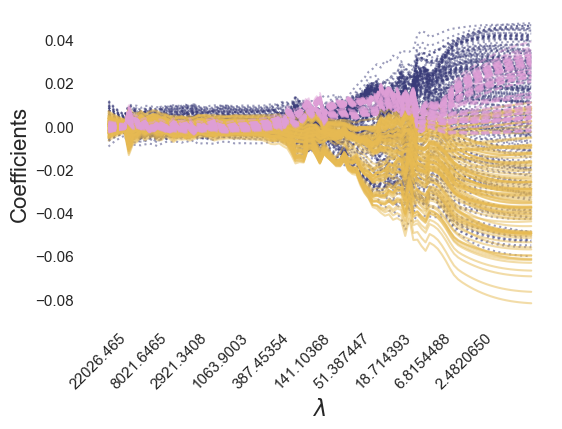

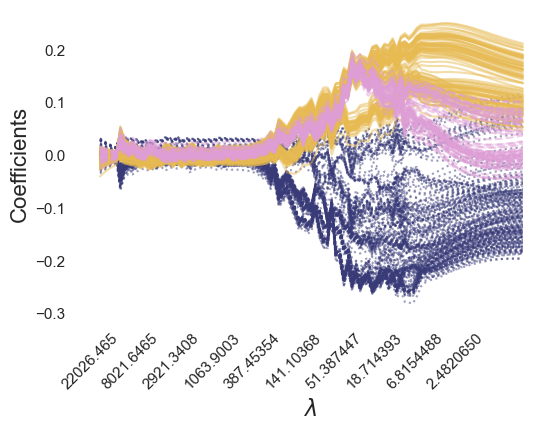

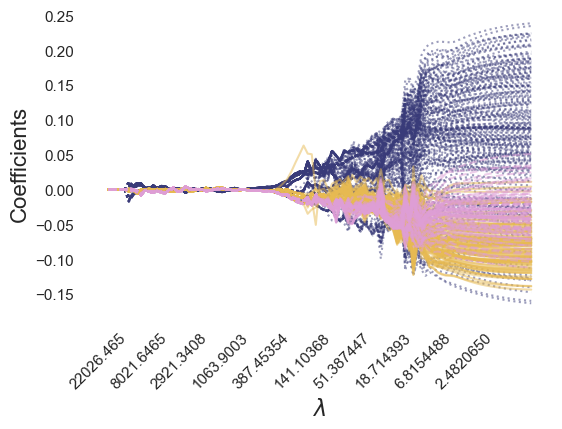

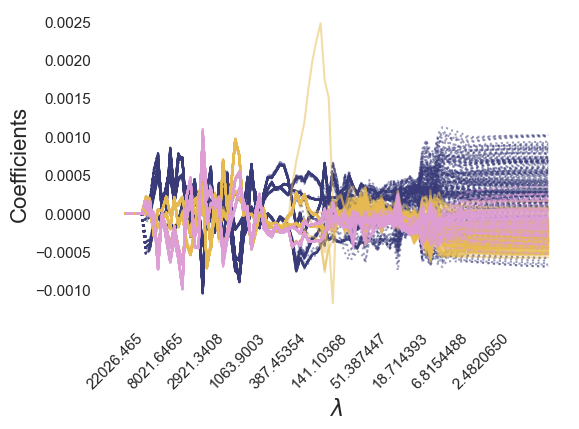

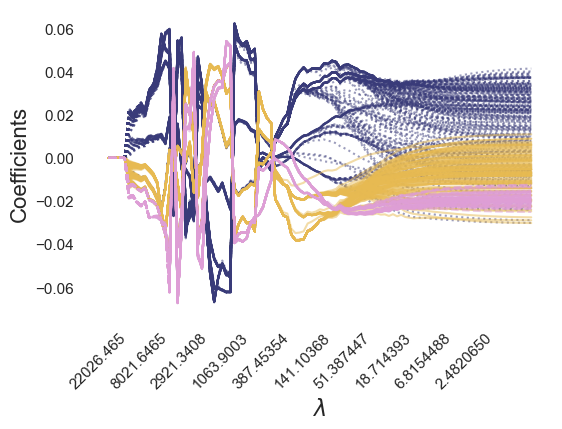

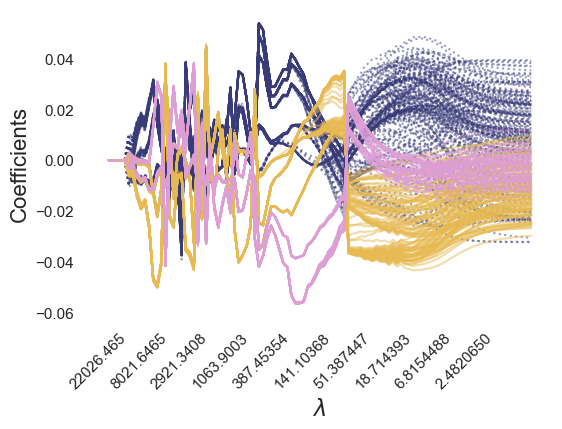

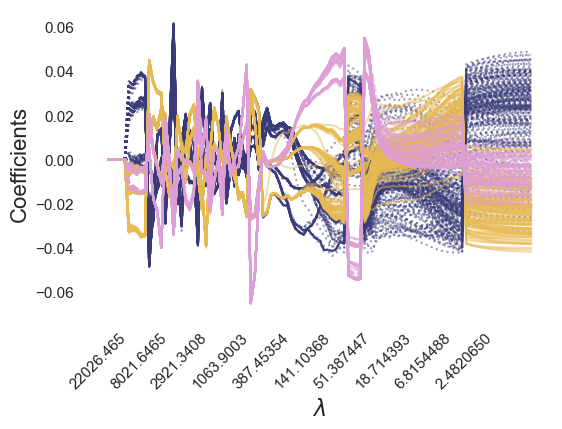

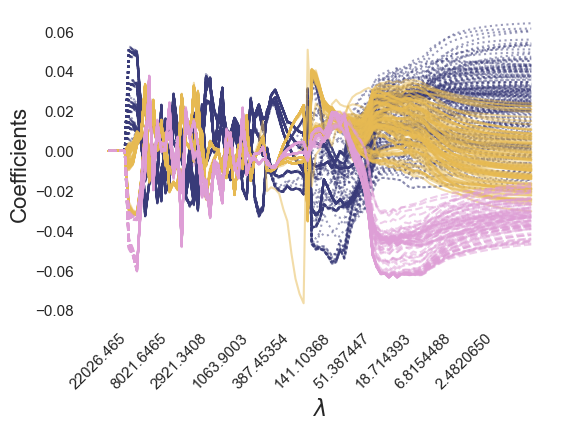

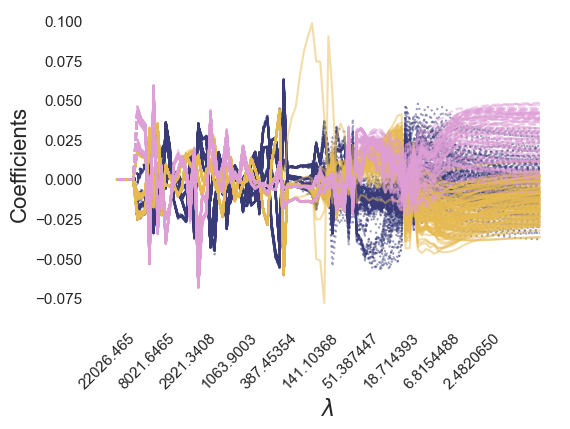

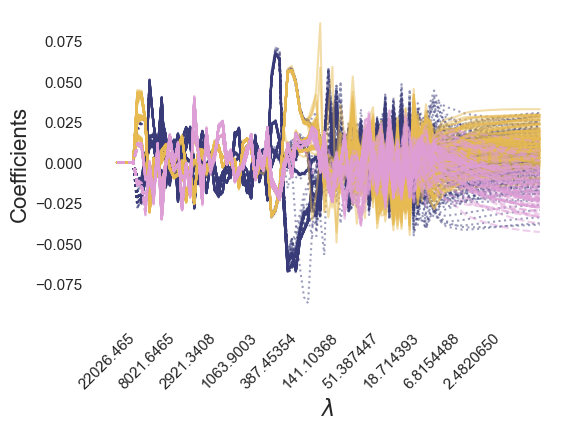

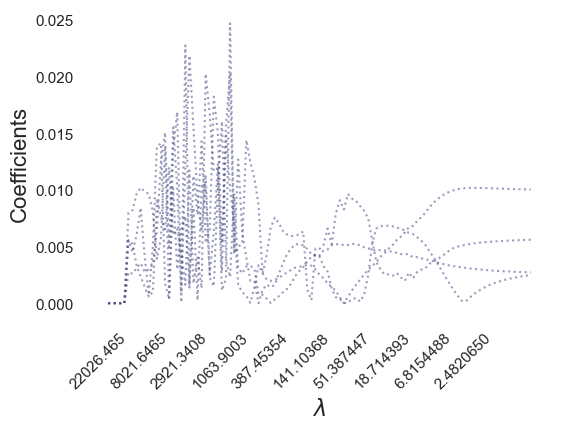

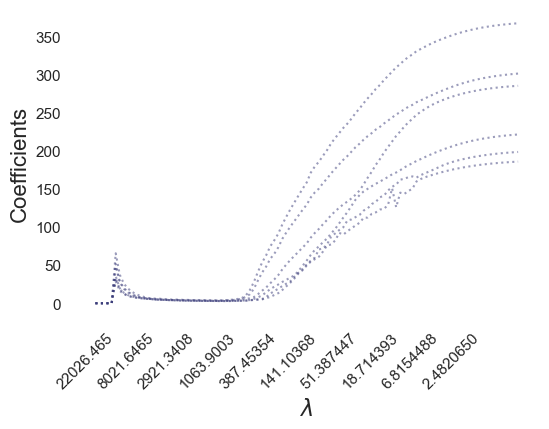

In [56]:
from matplotlib import pyplot as plt
def path_plot(coefficient_arr, penalty_list, plot_range=[0,-1], cut_vars=False, 
              first_vars_only=False, var_sel=1, true_clusters=None,figsize=(20,10), xticks=None):
    import numpy as np
    import matplotlib
    from matplotlib import pyplot as plt
    import seaborn as sns; sns.set()

    # Crop x axis (e.g, to remove 'burn-in' period at beginning)                                                         
    coefficient_arr = coefficient_arr[plot_range[0]:plot_range[1],:,:]
    penalty_list = penalty_list[plot_range[0]:plot_range[1]]
    if cut_vars is True:
        coefficient_arr = coefficient_arr[:,:,[1,2,coefficient_arr.shape[2]-1]]

    if first_vars_only is True:
        coefficient_arr = coefficient_arr[:,:,[var_sel]]

    # Colormap                                                                                                           
    cmap = matplotlib.cm.get_cmap('tab20b')

    #cm.get_cmap('viridis', coefficient_arr.shape[2])
    if true_clusters is not None:
        colors = cmap(np.linspace(0.0,1.0,len(np.unique(true_clusters)) ))
    else:
        colors = cmap(np.linspace(0.0,1.0,coefficient_arr.shape[1]))
    
    # Define x-axis range                                                                                                
    penalty_range = range(len(penalty_list))

    # Make figure
    fig, ax = plt.subplots(1,1, figsize=figsize)

    for i in range(coefficient_arr.shape[2]):
        x = np.round(np.array(penalty_list),8)[penalty_range]
        y = coefficient_arr[penalty_range,:,i]
        if true_clusters is not None:
            # Make different line types for different clusters
            linetypes = ['dotted']*len(true_clusters)
            color_list = [colors[i]]*len(true_clusters)
            for j, tc in enumerate(true_clusters):
                if tc == 1:
                    linetypes[j] = 'solid'
                    color_list[j] = colors[tc]
                elif tc == 2:
                    linetypes[j] = 'dashed'
                    color_list[j] = colors[tc]
                elif tc == 3:
                    linetypes[j] = 'dashdot'
                    color_list[j] = colors[tc]
                else:
                    linetypes[j] = 'dotted'
                    color_list[j] = colors[tc]

            # Plot the lines and set linestyle
            ax.plot(np.arange(x.shape[0]), y, color=colors[i], alpha=0.5)
            for l, line in enumerate(ax.get_lines()):
                line.set_linestyle(linetypes[l])
                line.set_color(color_list[l])
        else:
            ax.plot(np.arange(x.shape[0]), y, color=colors[i], alpha=0.5)
        # Set plot ticks and labels
        ax.set_facecolor('white')
        ax.set_xticks(range(x.shape[0]), minor=False);
        plt.setp(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
        x = [str(xx)[0:9] for xx in x]
        ax.set_xticklabels(x) #,fontsize=24)
        evens = np.arange(0,len(ax.xaxis.get_ticklabels())+1,2)
    for label in ax.xaxis.get_ticklabels()[::2]:
        label.set_visible(False) 
    ax.tick_params(axis='y') #, labelsize=24)
    plt.xlabel(r'$\lambda$',fontsize=16)
    plt.ylabel('Coefficients',fontsize=16)
    sns.despine()
    
skip=1

path_plot(np.mean(np.asarray(A),axis=2)[:,:,np.newaxis][:,::skip,:], penalty_list, plot_range=[0,len(penalty_list)],
          cut_vars=False, true_clusters=true_clusters_in, figsize=(6,4), 
          xticks=['134.2', '14.7' '1.6','0.2','0.02','0.002','0.0002','2.6e-5','2.5e-6','3.1e-7','3.0e-8','0.0']) 
plt.locator_params(axis='x',nbins=25)

path_plot(np.asarray(A)[:,:,6:7][:,::skip,:], penalty_list, plot_range=[0,len(penalty_list)],
          cut_vars=False, true_clusters=true_clusters_in, figsize=(6,4), 
          xticks=['134.2', '14.7' '1.6','0.2','0.02','0.002','0.0002','2.6e-5','2.5e-6','3.1e-7','3.0e-8','0.0']) 
plt.locator_params(axis='x',nbins=25)

path_plot(np.asarray(USV)[:,:,0:1][:,::skip,:], penalty_list, plot_range=[0,len(penalty_list)],
          cut_vars=False, true_clusters=true_clusters_in, figsize=(6,4), 
          xticks=['134.2', '14.7' '1.6','0.2','0.02','0.002','0.0002','2.6e-5','2.5e-6','3.1e-7','3.0e-8','0.0']) 
plt.locator_params(axis='x',nbins=25)

path_plot(np.asarray(UV)[:,:,0:1][:,::skip,:], penalty_list, plot_range=[0,len(penalty_list)],
          cut_vars=False, true_clusters=true_clusters_in, figsize=(6,4), 
          xticks=['134.2', '14.7' '1.6','0.2','0.02','0.002','0.0002','2.6e-5','2.5e-6','3.1e-7','3.0e-8','0.0']) 
plt.locator_params(axis='x',nbins=25)

path_plot(np.array(U)[:,:,0:1][:,::skip,:], penalty_list, plot_range=[0,len(penalty_list)],
          cut_vars=False, true_clusters=true_clusters_in,figsize=(6,4), 
          xticks=['134.2', '14.7' '1.6','0.2','0.02','0.002','0.0002','2.6e-5','2.5e-6','3.1e-7','3.0e-8','0.0']) 
plt.locator_params(axis='x',nbins=25)

path_plot(np.array(U)[:,:,1:2][:,::skip,:], penalty_list, plot_range=[0,len(penalty_list)],
          cut_vars=False, true_clusters=true_clusters_in,figsize=(6,4), 
          xticks=['134.2', '14.7' '1.6','0.2','0.02','0.002','0.0002','2.6e-5','2.5e-6','3.1e-7','3.0e-8','0.0']) 
plt.locator_params(axis='x',nbins=25)

path_plot(np.array(U)[:,:,2:3][:,::skip,:], penalty_list, plot_range=[0,len(penalty_list)],
          cut_vars=False, true_clusters=true_clusters_in,figsize=(6,4), 
          xticks=['134.2', '14.7' '1.6','0.2','0.02','0.002','0.0002','2.6e-5','2.5e-6','3.1e-7','3.0e-8','0.0']) 
plt.locator_params(axis='x',nbins=25)

path_plot(np.array(U)[:,:,3:4][:,::skip,:], penalty_list, plot_range=[0,len(penalty_list)],
          cut_vars=False, true_clusters=true_clusters_in,figsize=(6,4), 
          xticks=['134.2', '14.7' '1.6','0.2','0.02','0.002','0.0002','2.6e-5','2.5e-6','3.1e-7','3.0e-8','0.0']) 
plt.locator_params(axis='x',nbins=25)

path_plot(np.array(U)[:,:,4:5][:,::skip,:], penalty_list, plot_range=[0,len(penalty_list)],
          cut_vars=False, true_clusters=true_clusters_in,figsize=(6,4), 
          xticks=['134.2', '14.7' '1.6','0.2','0.02','0.002','0.0002','2.6e-5','2.5e-6','3.1e-7','3.0e-8','0.0']) 
plt.locator_params(axis='x',nbins=25)

path_plot(np.array(U)[:,:,5:6][:,::skip,:], penalty_list, plot_range=[0,len(penalty_list)],
          cut_vars=False, true_clusters=true_clusters_in,figsize=(6,4), 
          xticks=['134.2', '14.7' '1.6','0.2','0.02','0.002','0.0002','2.6e-5','2.5e-6','3.1e-7','3.0e-8','0.0']) 
plt.locator_params(axis='x',nbins=25)

path_plot(np.array(V)[:,0:4,0:1][:,::skip,:], penalty_list, plot_range=[0,len(penalty_list)],
          cut_vars=False, true_clusters=true_clusters_in,figsize=(6,4), 
          xticks=['134.2', '14.7' '1.6','0.2','0.02','0.002','0.0002','2.6e-5','2.5e-6','3.1e-7','3.0e-8','0.0']) 
plt.locator_params(axis='x',nbins=25)

path_plot(np.array(S)[:,:,:], penalty_list, plot_range=[0,len(penalty_list)],
          cut_vars=False, true_clusters=true_clusters_in,figsize=(6,4), 
          xticks=['134.2', '14.7' '1.6','0.2','0.02','0.002','0.0002','2.6e-5','2.5e-6','3.1e-7','3.0e-8','0.0']) 
plt.locator_params(axis='x',nbins=25)


In [63]:
import time
num_clusters = len(np.unique(true_clusters_in))
n_X = X_in.shape[1]
n_Y = X_in.shape[0]
NN = min(300,int(len(true_clusters_in[0:n_Y])/num_clusters))
for P in range(len(penalty_list)):
#     kmeans = KMeans(n_clusters=3, random_state=0).fit(np.array(UV[P]))
    if n_Y < 4000:
        spectral_clustering = SpectralClustering(affinity='nearest_neighbors', n_neighbors=NN, n_clusters=num_clusters).fit(np.array(UV[P]))
    #     spectral_clustering = SpectralClustering(affinity='nearest_neighbors', n_neighbors=int(len(true_clusters_in)/num_clusters), n_clusters=num_clusters).fit(np.array(USV[P]))
    #     spectral_clustering = SpectralClustering(affinity='nearest_neighbors', n_neighbors=int(len(true_clusters_in)/num_clusters), n_clusters=num_clusters).fit((np.array(U[P])[:,:]*np.array(S[P]).flatten()@np.array(V[P])[:,:]))
    #     spectral_clustering = SpectralClustering(affinity='nearest_neighbors', n_neighbors=int(len(true_clusters_in)/num_clusters), n_clusters=num_clusters).fit((np.array(U[P])[:,:]@np.array(V[P])[:,:]))
    #     spectral_clustering = SpectralClustering(affinity='nearest_neighbors', n_neighbors=int(len(true_clusters_in)/num_clusters), n_clusters=num_clusters).fit(np.array(A[P])[:,:])
    #     spectral_clustering = SpectralClustering(affinity='nearest_neighbors', n_neighbors=int(len(true_clusters_in)/num_clusters), n_clusters=num_clusters).fit(np.array(X_compB[P])[:,:])
        cs = spectral_clustering.labels_
    else:
        kmeans = KMeans(n_clusters=num_clusters, random_state=0).fit(np.array(UV[P]))
        cs = kmeans.labels_
    import sklearn
    
    conf_mat_ord = confusion_matrix_ordered(cs,true_clusters_in[0:n_Y])
    acc = np.sum(np.diag(conf_mat_ord))/np.sum(conf_mat_ord)
    print(P,sklearn.metrics.adjusted_rand_score(cs,true_clusters_in[0:n_Y]), acc)

if n_Y < 2000:
    # Fit PCMF
    tic=time.time()
    spectral_clustering = SpectralClustering(affinity='nearest_neighbors', n_neighbors=NN, n_clusters=num_clusters).fit(X_in[:,0:n_X])
    toc=time.time() - tic
    cs = spectral_clustering.labels_
    conf_mat_ord = confusion_matrix_ordered(cs,true_clusters_in[0:n_Y])
    acc = np.sum(np.diag(conf_mat_ord))/np.sum(conf_mat_ord)
    print('X_c spectral',sklearn.metrics.adjusted_rand_score(cs,true_clusters_in), acc, toc)
    
from sklearn.decomposition import PCA
tic=time.time()
pca = PCA(n_components=U[0].shape[1])
pca_in = pca.fit_transform(X_in[:,0:n_X])
if n_Y < 2:
    spectral_clustering = SpectralClustering(affinity='nearest_neighbors', n_neighbors=NN, n_clusters=num_clusters).fit(pca_in)
    toc=time.time() - tic
    cs = spectral_clustering.labels_
    conf_mat_ord = confusion_matrix_ordered(cs,true_clusters_in[0:n_Y])
    acc = np.sum(np.diag(conf_mat_ord))/np.sum(conf_mat_ord)
    print('X_c PCA1 spectral',sklearn.metrics.adjusted_rand_score(cs,true_clusters_in), acc, toc)
else:
    kmeans = KMeans(n_clusters=3, random_state=0).fit(pca_in)
    toc=time.time() - tic
    cs = kmeans.labels_
    conf_mat_ord = confusion_matrix_ordered(cs,true_clusters_in[0:n_Y])
    acc = np.sum(np.diag(conf_mat_ord))/np.sum(conf_mat_ord)
    print('X_c PCA1 kmeans',sklearn.metrics.adjusted_rand_score(cs,true_clusters_in), acc, toc)

k = problem_rank
tic=time.time()
u,d,vh = np.linalg.svd(X_in[:,0:n_X], full_matrices=False)
pca_in = ((u[:,0:k]*d[0:k]) @ vh[0:k,:])
pca_in = (u[:,0:k] @ vh[0:k,:])
if n_Y < 2:
    spectral_clustering = SpectralClustering(affinity='nearest_neighbors', n_neighbors=NN, n_clusters=num_clusters).fit(pca_in)
    toc=time.time() - tic
    cs = spectral_clustering.labels_
    conf_mat_ord = confusion_matrix_ordered(cs,true_clusters_in[0:n_Y])
    acc = np.sum(np.diag(conf_mat_ord))/np.sum(conf_mat_ord)
    print('X_c PCA2 spectral',sklearn.metrics.adjusted_rand_score(cs,true_clusters_in), acc, toc)
else:
    kmeans = KMeans(n_clusters=3, random_state=0).fit(pca_in)
    toc=time.time() - tic
    cs = kmeans.labels_
    conf_mat_ord = confusion_matrix_ordered(cs,true_clusters_in[0:n_Y])
    acc = np.sum(np.diag(conf_mat_ord))/np.sum(conf_mat_ord)
    print('X_c PCA2 kmeans',sklearn.metrics.adjusted_rand_score(cs,true_clusters_in), acc, toc)

kmeans = KMeans(n_clusters=3, random_state=0).fit(X_in[:,0:n_X])
cs = kmeans.labels_
conf_mat_ord = confusion_matrix_ordered(cs,true_clusters_in[0:n_Y])
acc = np.sum(np.diag(conf_mat_ord))/np.sum(conf_mat_ord)
print('X_c kmeans',sklearn.metrics.adjusted_rand_score(cs,true_clusters_in), acc, toc)

if n_Y < 2000:
    from sklearn.cluster import AgglomerativeClustering
    from sklearn.neighbors import kneighbors_graph
    tic=time.time()
    # connectivity matrix for structured Ward
    connectivity = kneighbors_graph(X_in[:,0:n_X], n_neighbors=NN, include_self=False)
    # make connectivity symmetric
    connectivity = 0.5 * (connectivity + connectivity.T)
    clustering = AgglomerativeClustering(n_clusters=num_clusters, linkage='ward', connectivity=connectivity).fit(X_in[:,0:n_X])
    toc=time.time() - tic
    cs = clustering.labels_
    acc = np.sum(np.diag(conf_mat_ord))/np.sum(conf_mat_ord)
    conf_mat_ord = confusion_matrix_ordered(cs,true_clusters_in[0:n_Y])
    print('X_c Ward',sklearn.metrics.adjusted_rand_score(cs,true_clusters_in),acc, toc)



0 0.12132902608939827 0.57
1 0.11478342536736359 0.57
2 0.009387540251691959 0.525
3 0.10811928829393075 0.5575
4 0.0838030258736156 0.545
5 0.8165804475373414 0.92
6 0.8165804475373414 0.92
7 0.5129590182716217 0.795
8 0.4780225686635606 0.795
9 0.8165804475373414 0.92
10 0.5778613084667868 0.8375
11 0.4780225686635606 0.795
12 0.4780225686635606 0.795
13 0.5652529741071498 0.8325
14 0.4780225686635606 0.795
15 0.46458547266046013 0.67
16 0.46667277572063237 0.7225
17 0.46423185137483886 0.7125
18 0.5129590182716217 0.795
19 0.4942473813252366 0.61
20 0.45723752815047597 0.7625
21 0.8165804475373414 0.92
22 0.8165804475373414 0.92
23 0.8165804475373414 0.92
24 0.4780225686635606 0.795
25 0.48787061384553854 0.6275
26 0.4483212910160332 0.64
27 0.4483212910160332 0.64
28 0.46423185137483886 0.7125
29 0.8165804475373414 0.92
30 0.4483212910160332 0.64
31 0.4483212910160332 0.64
32 0.4483212910160332 0.64
33 0.4483212910160332 0.64
34 0.5842496264096158 0.84
35 0.5204071208630583 0.815
3

In [78]:
import time
num_clusters = len(np.unique(true_clusters_in))
n_X = X_in.shape[1]
n_Y = X_in.shape[0]
NN = min(300,int(len(true_clusters_in[0:n_Y])/num_clusters))
for P in range(len(penalty_list)):
    print(P)
#     kmeans = KMeans(n_clusters=3, random_state=0).fit(np.array(UV[P]))
    if n_Y < 4000:
        spectral_clustering = SpectralClustering(affinity='nearest_neighbors', n_neighbors=NN, n_clusters=num_clusters).fit(np.array(UV[P]))
        cs = spectral_clustering.labels_
    else:
        kmeans = KMeans(n_clusters=num_clusters, random_state=0).fit(np.array(UV[P]))
        cs = kmeans.labels_
    PCMF_predict_clusters(X_in_test, UV[P], V, P, cs, PCMFtype='Full', true_clusters_test=true_clusters_in_test)
    PCMF_predict_clusters(X_in_test, X_in, V, P, cs, PCMFtype='Full', true_clusters_test=true_clusters_in_test)

# # %aimport 
# from pcmf import PCMF_predict_clusters
# for P in range(len(penalty_list)):
#     print(P)
#     PCMF_predict_clusters(X_in_test, UV[P], V, P, true_clusters_in, PCMFtype='Full', true_clusters_test=true_clusters_in_test)
#     PCMF_predict_clusters(X_in_test, X_in, V, P, true_clusters_in, PCMFtype='Full', true_clusters_test=true_clusters_in_test)



0
Test set cluster accuracy: 1.0
Test set cluster accuracy: 1.0
1
Test set cluster accuracy: 1.0
Test set cluster accuracy: 1.0
2
Test set cluster accuracy: 1.0
Test set cluster accuracy: 1.0
3
Test set cluster accuracy: 1.0
Test set cluster accuracy: 1.0
4
Test set cluster accuracy: 1.0
Test set cluster accuracy: 1.0
5
Test set cluster accuracy: 1.0
Test set cluster accuracy: 1.0
6
Test set cluster accuracy: 1.0
Test set cluster accuracy: 1.0
7
Test set cluster accuracy: 1.0
Test set cluster accuracy: 1.0
8
Test set cluster accuracy: 1.0
Test set cluster accuracy: 1.0
9
Test set cluster accuracy: 1.0
Test set cluster accuracy: 1.0
10
Test set cluster accuracy: 1.0
Test set cluster accuracy: 1.0
11
Test set cluster accuracy: 1.0
Test set cluster accuracy: 1.0
12
Test set cluster accuracy: 1.0
Test set cluster accuracy: 1.0
13
Test set cluster accuracy: 1.0
Test set cluster accuracy: 1.0
14
Test set cluster accuracy: 1.0
Test set cluster accuracy: 1.0
15
Test set cluster accuracy: 1.0
T

In [65]:

if n_Y < 2000:
    # Fit PCMF
    tic=time.time()
    spectral_clustering = SpectralClustering(affinity='nearest_neighbors', n_neighbors=NN, n_clusters=num_clusters).fit(X_in[:,0:n_X])
    toc=time.time() - tic
    cs = spectral_clustering.labels_
    conf_mat_ord = confusion_matrix_ordered(cs,true_clusters_in[0:n_Y])
    acc = np.sum(np.diag(conf_mat_ord))/np.sum(conf_mat_ord)
    print('X_c spectral',sklearn.metrics.adjusted_rand_score(cs,true_clusters_in), acc, toc)
    
from sklearn.decomposition import PCA
tic=time.time()
pca = PCA(n_components=U[0].shape[1])
pca_in = pca.fit_transform(X_in[:,0:n_X])
if n_Y < 2:
    spectral_clustering = SpectralClustering(affinity='nearest_neighbors', n_neighbors=NN, n_clusters=num_clusters).fit(pca_in)
    toc=time.time() - tic
    cs = spectral_clustering.labels_
    conf_mat_ord = confusion_matrix_ordered(cs,true_clusters_in[0:n_Y])
    acc = np.sum(np.diag(conf_mat_ord))/np.sum(conf_mat_ord)
    print('X_c PCA1 spectral',sklearn.metrics.adjusted_rand_score(cs,true_clusters_in), acc, toc)
else:
    kmeans = KMeans(n_clusters=3, random_state=0).fit(pca_in)
    toc=time.time() - tic
    cs = kmeans.labels_
    conf_mat_ord = confusion_matrix_ordered(cs,true_clusters_in[0:n_Y])
    acc = np.sum(np.diag(conf_mat_ord))/np.sum(conf_mat_ord)
    print('X_c PCA1 kmeans',sklearn.metrics.adjusted_rand_score(cs,true_clusters_in), acc, toc)

k = problem_rank
tic=time.time()
u,d,vh = np.linalg.svd(X_in[:,0:n_X], full_matrices=False)
pca_in = ((u[:,0:k]*d[0:k]) @ vh[0:k,:])
# pca_in = (u[:,0:k] @ vh[0:k,:])
if n_Y < 2:
    spectral_clustering = SpectralClustering(affinity='nearest_neighbors', n_neighbors=NN, n_clusters=num_clusters).fit(pca_in)
    toc=time.time() - tic
    cs = spectral_clustering.labels_
    conf_mat_ord = confusion_matrix_ordered(cs,true_clusters_in[0:n_Y])
    acc = np.sum(np.diag(conf_mat_ord))/np.sum(conf_mat_ord)
    print('X_c PCA2 spectral',sklearn.metrics.adjusted_rand_score(cs,true_clusters_in), acc, toc)
else:
    kmeans = KMeans(n_clusters=3, random_state=0).fit(pca_in)
    toc=time.time() - tic
    cs = kmeans.labels_
    conf_mat_ord = confusion_matrix_ordered(cs,true_clusters_in[0:n_Y])
    acc = np.sum(np.diag(conf_mat_ord))/np.sum(conf_mat_ord)
    print('X_c PCA2 kmeans',sklearn.metrics.adjusted_rand_score(cs,true_clusters_in), acc, toc)

kmeans = KMeans(n_clusters=3, random_state=0).fit(X_in[:,0:n_X])
cs = kmeans.labels_
conf_mat_ord = confusion_matrix_ordered(cs,true_clusters_in[0:n_Y])
acc = np.sum(np.diag(conf_mat_ord))/np.sum(conf_mat_ord)
print('X_c kmeans',sklearn.metrics.adjusted_rand_score(cs,true_clusters_in), acc, toc)

if n_Y < 2000:
    from sklearn.cluster import AgglomerativeClustering
    from sklearn.neighbors import kneighbors_graph
    tic=time.time()
    # connectivity matrix for structured Ward
    connectivity = kneighbors_graph(X_in[:,0:n_X], n_neighbors=NN, include_self=False)
    # make connectivity symmetric
    connectivity = 0.5 * (connectivity + connectivity.T)
    clustering = AgglomerativeClustering(n_clusters=num_clusters, linkage='ward', connectivity=connectivity).fit(X_in[:,0:n_X])
    toc=time.time() - tic
    cs = clustering.labels_
    acc = np.sum(np.diag(conf_mat_ord))/np.sum(conf_mat_ord)
    conf_mat_ord = confusion_matrix_ordered(cs,true_clusters_in[0:n_Y])
    print('X_c Ward',sklearn.metrics.adjusted_rand_score(cs,true_clusters_in),acc, toc)



X_c spectral 0.7664034771883522 0.92 0.12147712707519531
X_c PCA1 kmeans 0.7044001900285499 0.8975 0.09884214401245117
X_c PCA2 kmeans 0.7044001900285499 0.8975 0.8909740447998047
X_c kmeans 0.7213378673386986 0.905 0.8909740447998047
X_c Ward 0.7419589752913139 0.905 1.3473379611968994


In [74]:
conf_mat_ord = confusion_matrix_ordered(cs,true_clusters_in[0:n_Y])
conf_mat_ord

array([[106,  34,   0],
       [  0, 179,   0],
       [  0,   0,  81]])

In [75]:
k = problem_rank
u,d,vh = np.linalg.svd(X_in[:,0:n_X], full_matrices=False)
pca_in = ((u[:,0:k]*d[0:k]) @ vh[0:k,:])
kmeans = KMeans(n_clusters=3, random_state=0).fit(pca_in)
train_clusters = kmeans.labels_

PCMF_predict_clusters(X_in_test, X_in, vh[np.newaxis,:,:], 0, train_clusters, PCMFtype='Full', true_clusters_test=true_clusters_in_test)
# PCMF_predict_clusters(X_in_test, X_in, V, P, true_clusters_in, PCMFtype='Full', true_clusters_test=true_clusters_in_test)



Test set cluster accuracy: 1.0


(array([[ 5.68875646e+01, -4.95995876e+00, -1.07010367e+00, ...,
          1.12684477e-04,  1.17050890e-02,  1.12990035e-13],
        [-4.10612060e+01, -2.47706509e+01,  4.28959399e+00, ...,
         -3.83757329e-02,  4.84309973e-02,  1.57193465e-13],
        [-2.57958866e+01,  2.90004191e+01, -7.10236776e+00, ...,
          2.26656435e-02, -4.20922958e-02,  1.43786643e-13]]),
 array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1]),
 array([[-4.59412565e+01, -7.36507628e+00,  1.90966954e+01, ...,
          1.84834036e-01,  7.07129965e-03,  1.76972909e-01],
        [-5.07976927e+01, -6.11945265e+00,  1.06089361e+01, ...,
          1.96262064e-01,  1.00353629e+00,  3.63193996e-01],
        [-5.22799311e+01, -1.59879953e+01,  9.71166181e+00, ...,
          7.84070245e-01,  1.07199456e+00, -9.92856295e-01],
        ...,
        [-2.69002887e+01, -1.66480196e+01,  3.68693084e+01, ...,
          5.64872023e-01,  3.31622824e-02, -1.88775558e+00],
        [-3.3

In [59]:
print(toc)

1.2723960876464844


In [ ]:
P = 87

rounds = [2,3,4,7]
spectral_clustering = SpectralClustering(affinity='nearest_neighbors', n_neighbors=int(len(true_clusters_train)/num_clusters), n_clusters=num_clusters).fit(np.array(UV[P]))
cs = spectral_clustering.labels_
import sklearn
print(sklearn.metrics.adjusted_rand_score(cs,true_clusters_train))
# Plot PCA

fig = plt.figure(figsize=(16,4))
gs = fig.add_gridspec(1, 4, hspace=0, wspace=0)
axs = gs.subplots(sharex=True, sharey=True)
# fig.suptitle(r'Three Classes $p=%i$;'%n_X + ' $N_1=%i$;'%m[0]+' $N_2=%i$;'%m[1]+' $N_3=%i$'%m[2])

for a,ax in enumerate(axs):
    for nc in range(num_clusters):
        idx = np.where(cs==nc)[0]
        ax.scatter(X_compA[P,idx, a:a+1], X_compA[P,idx, a+1:a+2], c=colors[nc])
        
    ax.set(xlabel="Variable "+str(a))
    ax.patch.set_facecolor('white')
#     ax.set(ylabel="Variable "+str(a+1))
    ax.text(0.95, 0.01, r"$\lambda =$"+str(np.round(penalty_list[a],rounds[a])),
        verticalalignment='bottom', horizontalalignment='right',
        transform=ax.transAxes,
        color='black', fontsize=12)

fig = plt.figure(figsize=(16,4))
gs = fig.add_gridspec(1, 4, hspace=0, wspace=0)
axs = gs.subplots(sharex=True, sharey=True)

for a,ax in enumerate(axs):
    for nc in range(num_clusters):
        idx = np.where(cs==nc)[0]
        ax.scatter(X_compB[P,idx, a:a+1], X_compB[P,idx, a+1:a+2], c=colors[nc])
        
    ax.set(xlabel="Variable "+str(a))
    ax.patch.set_facecolor('white')
#     ax.set(ylabel="Variable "+str(a+1))
    ax.text(0.95, 0.01, r"$\lambda =$"+str(np.round(penalty_list[a],rounds[a])),
        verticalalignment='bottom', horizontalalignment='right',
        transform=ax.transAxes,
        color='black', fontsize=12)

# Plot PCA
cs = true_clusters_train
fig = plt.figure(figsize=(16,4))
gs = fig.add_gridspec(1, 4, hspace=0, wspace=0)
axs = gs.subplots(sharex=True, sharey=True)
# fig.suptitle(r'Three Classes $p=%i$;'%n_X + ' $N_1=%i$;'%m[0]+' $N_2=%i$;'%m[1]+' $N_3=%i$'%m[2])

for a,ax in enumerate(axs):
    for nc in range(num_clusters):
        idx = np.where(cs==nc)[0]
        ax.scatter(X_compB[P,idx, a:a+1], X_compB[P,idx, a+1:a+2], c=colors[nc])
        
    ax.set(xlabel="Variable "+str(a))
    ax.patch.set_facecolor('white')
#     ax.set(ylabel="Variable "+str(a+1))
    ax.text(0.95, 0.01, r"$\lambda =$"+str(np.round(penalty_list[a],rounds[a])),
        verticalalignment='bottom', horizontalalignment='right',
        transform=ax.transAxes,
        color='black', fontsize=12)

# Plot PCA
cs = true_clusters_train
fig = plt.figure(figsize=(16,4))
gs = fig.add_gridspec(1, 4, hspace=0, wspace=0)
axs = gs.subplots(sharex=True, sharey=True)
# fig.suptitle(r'Three Classes $p=%i$;'%n_X + ' $N_1=%i$;'%m[0]+' $N_2=%i$;'%m[1]+' $N_3=%i$'%m[2])

for a,ax in enumerate(axs):
    for nc in range(num_clusters):
        idx = np.where(cs==nc)[0]
        ax.scatter(X_compA[P,idx, a:a+1], X_compA[P,idx, a+1:a+2], c=colors[nc])
        
    ax.set(xlabel="Variable "+str(a))
    ax.patch.set_facecolor('white')
#     ax.set(ylabel="Variable "+str(a+1))
    ax.text(0.95, 0.01, r"$\lambda =$"+str(np.round(penalty_list[a],rounds[a])),
        verticalalignment='bottom', horizontalalignment='right',
        transform=ax.transAxes,
        color='black', fontsize=12)
    



In [18]:
sklearn.__version__

'1.2.0'

In [224]:
from numba import jit, prange
from sklearn.neighbors import NearestNeighbors
from scipy import stats

@jit(nopython=False, parallel=True, fastmath=True)
def predict_NN(neighbors, X_in_test, X_in, true_clusters_in, true_clusters_in_test, true_clusters_test_predict):
    true_clusters_test_predict2 = []
    print(X_in_test.shape, true_clusters_in_test.shape, true_clusters_test_predict.shape, X_in.shape, true_clusters_in.shape)
    for i in prange(X_in_test.shape[0]):
        nbrs = NearestNeighbors(n_neighbors=int(neighbors), algorithm='ball_tree').fit(np.vstack((X_in_test[i,:],X_in)))
        _, indices = nbrs.kneighbors(np.vstack((X_in_test[i,:],X_in)))
        NN_train_inds = np.array(indices)[0,:][1:neighbors]-1
        mode, count = stats.mode(true_clusters_in[NN_train_inds])
        cl = int(mode)
        true_clusters_test_predict2.append(cl)
        print(i, cl, true_clusters_test_predict[i], true_clusters_in_test[i])
        
    return np.array(true_clusters_test_predict2)



In [312]:
P = 7
XV_c, true_clusters_test_predict, XV_test, cluster_acc = PCMF_predict_clusters(X_in_test, X_in, V, P, true_clusters_in, PCMFtype='Full', true_clusters_test=true_clusters_in_test)
# true_clusters_test_predict2 = predict_NN(20, X_in_test[::20], X_in[::5], true_clusters_in[::5], true_clusters_in_test[::20], true_clusters_test_predict[::20])
# true_clusters_test_predict2 = predict_NN(10, XV_test[::20], UV[P][::2]@np.array(V[P]).T, true_clusters_in[::2], true_clusters_in_test[::20], true_clusters_test_predict[::20])
true_clusters_test_predict2 = predict_NN(10, XV_test[::20], X_in[::2]@np.array(V[P]).T, true_clusters_in[::2], true_clusters_in_test[::20], true_clusters_test_predict[::20])

conf_mat_ord = confusion_matrix_ordered(true_clusters_test_predict2, true_clusters_in_test[::20])
np.sum(np.diag(conf_mat_ord))/np.sum(conf_mat_ord)


Test set cluster accuracy: 0.8783 0.4867
(302, 100) (302,) (302,) (1800, 100) (1800,)
0 0 0 0
1 0 0 0
2 0 0 0
3 0 0 0
4 0 0 0
5 0 0 0
6 0 0 0
7 0 0 0
8 0 0 0
9 0 5 0
10 0 0 0
11 0 0 0
12 0 5 0
13 0 0 0
14 0 0 0
15 0 0 0
16 0 0 0
17 0 5 0
18 0 0 0
19 0 0 0
20 0 0 0
21 0 0 0
22 0 0 0
23 0 0 0
24 0 0 0
25 0 0 0
26 0 0 0
27 0 0 0
28 0 0 0
29 0 0 0
30 0 0 0
31 0 0 0
32 0 0 0
33 0 2 0
34 0 0 0
35 0 0 0
36 0 0 0
37 0 0 0
38 0 0 0
39 0 0 0
40 0 0 0
41 0 0 0
42 0 0 0
43 0 0 0
44 0 0 0
45 0 0 0
46 0 0 0
47 0 0 0
48 0 0 0
49 1 1 1
50 1 1 1
51 1 1 1
52 1 1 1
53 1 1 1
54 1 1 1
55 1 1 1
56 1 1 1
57 1 1 1
58 2 2 1
59 1 1 1
60 1 1 1
61 1 1 1
62 1 1 1
63 1 1 1
64 1 1 1
65 1 1 1
66 1 1 1
67 1 1 1
68 1 1 1
69 1 1 1
70 1 1 1
71 1 1 1
72 1 1 1
73 1 1 1
74 1 1 1
75 1 1 1
76 1 1 1
77 1 1 1
78 1 1 1
79 1 1 1
80 1 1 1
81 1 1 1
82 1 1 1
83 1 1 1
84 1 1 1
85 1 1 1
86 1 1 1
87 1 1 1
88 1 1 1
89 1 1 1
90 1 1 1
91 1 1 1
92 1 1 1
93 1 1 1
94 1 1 1
95 1 1 1
96 1 1 1
97 1 1 1
98 1 1 1
99 1 1 1
100 1 1 1
101 1 1 1
102 

0.9304635761589404

In [316]:
from pcmf import SVD
u,s,v = SVD(X_in,100)
v

array([[ 1.07619220e-18,  5.55111512e-17,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [-1.72049921e-18,  0.00000000e+00, -2.77555756e-17, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 4.94999277e-19, -1.38777878e-17,  3.46944695e-18, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       ...,
       [ 1.14368652e-18, -5.37764278e-17, -3.46944695e-17, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [-3.26692106e-18,  0.00000000e+00,  6.24500451e-17, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [-5.57183578e-18, -6.93889390e-18,  5.55111512e-17, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00]])

In [367]:
print(np.corrcoef(U[P][:,0:2].T,u[:,0:2].T))
# print(np.corrcoef(V[P][0:2,:],v[0:2,:]))

[[ 1.         -0.26224413  0.36923216  0.84888615]
 [-0.26224413  1.         -0.93602809  0.11588966]
 [ 0.36923216 -0.93602809  1.         -0.0021828 ]
 [ 0.84888615  0.11588966 -0.0021828   1.        ]]


In [261]:
# from pcmf import PCMF_predict_clusters
# from numba import jit, prange

# XV_c, true_clusters_test_predict, XV_test, cluster_acc = PCMF_predict_clusters(X_in_test, UV[P], V, P, true_clusters_in, PCMFtype='Full', true_clusters_test=true_clusters_in_test)
# print(true_clusters_test_predict.shape)

# from sklearn.neighbors import NearestNeighbors
# from scipy import stats
# true_clusters_test_predict2 = []
# for i in range(100): #X_in_test.shape[0]):
#     nbrs = NearestNeighbors(n_neighbors=int(neighbors), algorithm='ball_tree').fit(np.vstack((X_in_test[i,:],X_in)))
#     _, indices = nbrs.kneighbors(np.vstack((X_in_test[i,:],X_in)))
#     NN_train_inds = np.array(indices)[0,:][1:neighbors]-1
#     mode, count = stats.mode(true_clusters_in[NN_train_inds])
#     cl = int(mode)
#     true_clusters_test_predict2.append(cl)
#     print(i, cl, true_clusters_test_predict[i])


In [204]:
# X_in[::30].shape
# neighbors
# # X_in_test[::20].shape
# for i in np.arange(0,10000,200):
#     nbrs = NearestNeighbors(n_neighbors=int(neighbors), algorithm='ball_tree').fit(np.vstack((X_in_test[i,:],X_in)))
#     _, indices = nbrs.kneighbors(np.vstack((X_in_test[i,:],X_in)))
#     NN_train_inds = np.array(indices)[0,:][1:neighbors]-1
#     mode, count = stats.mode(true_clusters_in[NN_train_inds])
#     cl = int(mode)
#     print(i, true_clusters_in_test[i], cl)

In [57]:
# %autoreload 1
# # import sys
# sys.modules.pop('pcmf')

<module 'pcmf' from '/Users/amandabuch/Documents/clusterCCA/PCMF/pcmf.py'>

In [58]:
# cd /Users/amandabuch/Documents/clusterCCA/PCMF/

/Users/amandabuch/Documents/clusterCCA/PCMF


In [292]:
np.sum(true_clusters_test_predict[::20]==true_clusters_in_test[::20])/len(true_clusters_in_test[::20])

np.sum(true_clusters_test_predict2==true_clusters_in_test[::20])/len(true_clusters_in_test[::20])


0.9238410596026491

In [151]:
i = 5000
neighbors=40
nbrs = NearestNeighbors(n_neighbors=int(neighbors), algorithm='ball_tree').fit(np.vstack((X_in_test[i,:],X_in[::10])))
_, indices = nbrs.kneighbors(np.vstack((X_in_test[i,:],X_in)))
cl = stats.mode(true_clusters_in[::10][indices[0,:]])[0][0]
true_clusters_test_predict2.append(cl)
print(i, cl, true_clusters_test_predict[i], true_clusters_in_test[i])



5000 4 4 4


In [128]:
def PCMF_predict_clusters(X_test, X_train, V, p, true_clusters_train, neighbors=25, PCMFtype='Full', true_clusters_test=None):# Get cluster PCA component
    '''Function to take held out test data and project it to PCA component and predict clusters
       Inputs:  X_test: n_test x p (already centered using np.mean(X_train, axis=0))
                X_train: n_train x p  (already centered using np.mean(X_train, axis=0))
                V: #penalties x r x p; list output of PCMF_Full of rank r
                p: penalty index on path
                true_clusters_train: n_train x 1; true cluster labels for training set
                true_clusters_test: n_test x 1; Optional argument; if available, the true labels for test set to get accuracy
    '''
    from scipy.spatial.distance import cdist
    from sklearn.neighbors import NearestNeighbors
    
    XV_c = []
    if PCMFtype is 'Full':
        for cluster in np.unique(true_clusters_train):
            XV_c.append(np.mean((X_train[true_clusters_train==cluster,:] @ np.array(V)[p,:,:].T),0))
        XV_test = (X_test @ np.array(V)[p,:,:].T)
        
        cluster_dist = cdist( XV_test, XV_c )

        # for cluster in np.unique(true_clusters_train):
        #     XV_c.append(np.median((X_train[true_clusters_train==cluster,:] @ np.array(V)[p,:,:].T),0))
        # XV_test = (X_test @ np.array(V)[p,:,:].T)

        for i in range(X_test.shape[0]):
            nbrs = NearestNeighbors(n_neighbors=neighbors, algorithm='ball_tree').fit(np.vstack((X_in_test[i,:],X_train)))
        
        cluster_dist2 = cdist( XV_test, XV_c )
        
    elif PCMFtype is 'PALS':
        for cluster in np.unique(true_clusters_train):
            XV_c.append(np.mean((X_train[true_clusters_train==cluster,:] @ np.mean(np.array(V)[p,true_clusters_train==cluster,:], axis=0)[:, np.newaxis] ),0) )
        XV_test = (X_test @ np.mean(np.array(V)[p,true_clusters_train==cluster,:], axis=0)[:, np.newaxis])
        
        cluster_dist = []
        for cluster in np.unique(true_clusters_train):
            cluster_dist.append( cdist( XV_tests[cluster], XV_c[cluster:cluster+1] )[:,0] ) 
        cluster_dist = np.array(cluster_dist).T

    else:
        print("Wrong PCMFtype: ", PCMFtype)
        return [], [], [], []
            
    XV_c = np.array(XV_c)

    # Project new subjects and assign to clusters
    true_clusters_test_predict = np.argmin(cluster_dist, 1)
    true_clusters_test_predict2 = np.argmin(cluster_dist2, 1)

    if len(true_clusters_test)>1:
        # Check alignment to true clusters
        conf_mat_ord = confusion_matrix_ordered(true_clusters_test_predict, true_clusters_test)
        cluster_acc = np.sum(np.diag(conf_mat_ord))/np.sum(conf_mat_ord)
        conf_mat_ord = confusion_matrix_ordered(true_clusters_test_predict2, true_clusters_test)
        cluster_acc2= np.sum(np.diag(conf_mat_ord))/np.sum(conf_mat_ord)
        # cluster_acc2 = np.sum(true_clusters_test == true_clusters_test_predict) / len(true_clusters_test)
        print('Test set cluster accuracy:', np.round(cluster_acc,4), np.round(cluster_acc2,4))
    else:
        cluster_acc = []

    return XV_c, true_clusters_test_predict, XV_test, cluster_acc


In [4]:
os.environ['R_HOME'] = "/Library/Frameworks/R.framework/Resources/"
import rpy2.robjects as robjects
import rpy2.rinterface as rinterface
from rpy2.robjects.packages import importr
base = importr('base')
conflicted = importr('conflicted')
VarSelLCM = importr('VarSelLCM')

In [105]:
import os
import sys
import multiprocessing  
import time
import numpy as np

from sklearn.cluster import AgglomerativeClustering
from sklearn.neighbors import kneighbors_graph
from sklearn.cross_decomposition import CCA
from sklearn.cluster import SpectralClustering
from sklearn import mixture
from sklearn.cluster import KMeans
# from sklearn.metrics.cluster import normalized_mutual_info_score as NMI_score, adjusted_rand_score as ARI_score
from sklearn.metrics.cluster import normalized_mutual_info_score as NMI_score, adjusted_rand_score as ARI_score, rand_score as rand_score
from sklearn.metrics import davies_bouldin_score, silhouette_score, calinski_harabasz_score, mean_squared_error # cohen_kappa_score, hinge_loss, coverage_error, consensus_score
from sklearn.metrics import confusion_matrix, accuracy_score
from scipy.optimize import linprog
from scipy.optimize import linear_sum_assignment as linear_assignment

import warnings
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=DeprecationWarning)
    mixture.BayesianGaussianMixture()

if not sys.warnoptions:
    warnings.simplefilter("ignore")
    os.environ["PYTHONWARNINGS"] = ('ignore::UserWarning,ignore::ConvergenceWarning,ignore::RuntimeWarning')

# # os.environ['R_HOME'] = "/Library/Frameworks/R.framework/Resources/"
# import rpy2.robjects as robjects
# import rpy2.rinterface as rinterface
# from rpy2.robjects.packages import importr
# base = importr('base')
# conflicted = importr('conflicted')
# VarSelLCM = importr('VarSelLCM')

os.chdir('..')


# from cluster.selfrepresentation import ElasticNetSubspaceClustering

def smap(f):
    return f()

# def smap(f_args):
#     f, *args = f_args
#     return f(*args)

def calculate_scores_nonpath(pred_clusters, true_clusters):
    """
    Calculate cluster accuracy scores and requires true clusters
    Calls cluster_along_path on each index i along penalties in path
    Params:
        true_clusters
        path_length
    Returns:
        path_clusters = list of clusterings at each penalty on path
        nmi_score = np-array of normalized mutual information score for each penalty
        adj_rand_score = np-array of adjusted rand score for each penalty
        rand_score = np-array of rand score for each penalty
        mse_score = np-array of mean squared error score for each penalty
    """
    nmi_score = NMI_score(true_clusters, pred_clusters, average_method='arithmetic')
    adj_rand_score = ARI_score(true_clusters, pred_clusters)
    ri_score = rand_score(true_clusters, pred_clusters)
    mse_score = mean_squared_error(true_clusters, pred_clusters)
     
    return nmi_score, adj_rand_score, ri_score, mse_score


def confusion_matrix_ordered(pred, true):
    def _make_cost_m(cm):
        s = np.max(cm)
        return (- cm + s)
    conf_mat = confusion_matrix(pred,true)
    indexes = linear_assignment(_make_cost_m(conf_mat))
    js = [e for e in sorted(indexes, key=lambda x: x[0])[1]]
    conf_mat_ord = conf_mat[:, js]
    return conf_mat_ord

def fit_pca_kmeans(X, true_clusters, n_clusters):
    '''CCA + Kmeans clustering'''
    from sklearn.cluster import KMeans
    # Fit PCA-kmeans
    u,d,vh = np.linalg.svd(X, full_matrices=False)
    Xhat = u[:,0].reshape((X.shape[0], 1))*vh[0,:].reshape((1, X.shape[1]))
    kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(Xhat)
    labels = kmeans.labels_
    #
    # Calculate scores
    nmi, ari, ri, mse = calculate_scores_nonpath(labels, true_clusters)
    # Calculate accuracy
    conf_mat_ord = confusion_matrix_ordered(labels,true_clusters)
    acc = np.sum(np.diag(conf_mat_ord))/np.sum(conf_mat_ord)
    #
    return labels, ari, nmi, acc

def fit_ward(X, true_clusters, n_clusters):
    '''Ward clustering'''
    from sklearn.cluster import AgglomerativeClustering
    from sklearn.neighbors import kneighbors_graph
    #
    data_in = X
    #
    # connectivity matrix for structured Ward
    connectivity = kneighbors_graph(data_in, n_neighbors=10, include_self=False)
    # make connectivity symmetric
    connectivity = 0.5 * (connectivity + connectivity.T)
    #
    clustering = AgglomerativeClustering(n_clusters=n_clusters, linkage='ward', connectivity=connectivity).fit(data_in)
    labels = clustering.labels_    
    #
    # Calculate scores
    nmi, ari, ri, mse = calculate_scores_nonpath(labels, true_clusters)
    # Calculate accuracy
    conf_mat_ord = confusion_matrix_ordered(labels,true_clusters)
    acc = np.sum(np.diag(conf_mat_ord))/np.sum(conf_mat_ord)
    #
    return labels, ari, nmi, acc

def fit_spectral(X, true_clusters, n_clusters):
    '''Spectral clustering'''
    from sklearn.cluster import SpectralClustering
    #
    data_in = X
    #
    spectral_clustering = SpectralClustering(n_clusters=n_clusters, random_state=20, affinity="nearest_neighbors").fit(data_in)
    labels = spectral_clustering.labels_
    #
    # Calculate scores
    nmi, ari, ri, mse = calculate_scores_nonpath(labels, true_clusters)
    # Calculate accuracy
    conf_mat_ord = confusion_matrix_ordered(labels,true_clusters)
    acc = np.sum(np.diag(conf_mat_ord))/np.sum(conf_mat_ord)
    #
    return labels, ari, nmi, acc

def fit_dpgmm(X, true_clusters, n_clusters):
    '''DPGMM clustering'''
    from sklearn import mixture
    #
    data_in = X
    #
    dpgmm = mixture.BayesianGaussianMixture(n_components=n_clusters, covariance_type='full', weight_concentration_prior_type='dirichlet_process',max_iter=1000)
    dpgmm_mod = dpgmm.fit(data_in)
    labels = dpgmm.predict(data_in)
    #
    # Calculate scores
    nmi, ari, ri, mse = calculate_scores_nonpath(labels, true_clusters)
    # Calculate accuracy
    conf_mat_ord = confusion_matrix_ordered(labels,true_clusters)
    acc = np.sum(np.diag(conf_mat_ord))/np.sum(conf_mat_ord)
    #
    return labels, ari, nmi, acc

def fit_elasticnetsubspace(X, true_clusters, n_clusters):
    '''Elastic net clustering'''
    from cluster.selfrepresentation import ElasticNetSubspaceClustering
    #
    data_in = X
    #
    essc = ElasticNetSubspaceClustering(n_clusters=n_clusters, algorithm='spams', gamma=5, active_support=False, tau=0.1).fit(data_in)
    labels = essc.labels_
    #
    # Calculate scores
    nmi, ari, ri, mse = calculate_scores_nonpath(labels, true_clusters)
    # Calculate accuracy
    conf_mat_ord = confusion_matrix_ordered(labels,true_clusters)
    acc = np.sum(np.diag(conf_mat_ord))/np.sum(conf_mat_ord)
    #
    return labels, ari, nmi, acc

def fit_gMADD(X, true_clusters, n_clusters):
    '''gMADD clustering'''    #                                                                                                          
    from rpy2.robjects.packages import importr
    base = importr('base')
    utils = importr('utils')
    conflicted = importr('conflicted')
    HDLSSkST = importr('HDLSSkST')
    import rpy2.robjects.numpy2ri
    rpy2.robjects.numpy2ri.activate()
    rpy2.robjects.r('''                                                                                                                       
            # create a function `f`                                                                                                      
            f = function(X,true_clusters,n_clusters) {                                                                                                                                                                                                              
                N = dim(X)[1]                                                                                                            
                labels = gMADD(1,1,n_clusters,1,X)                                                                                             
                return(labels)                                                                                                           
            }                                                                                                                            
            # call the function `f` with argument value 3                                                                                
            ''')
    r_f = rpy2.robjects.globalenv['f']
    labels = r_f(X,true_clusters,n_clusters)
    #
    # Calculate scores
    nmi, ari, ri, mse = calculate_scores_nonpath(labels, true_clusters)
    # Calculate accuracy
    conf_mat_ord = confusion_matrix_ordered(labels,true_clusters)
    acc = np.sum(np.diag(conf_mat_ord))/np.sum(conf_mat_ord)
    #
    return labels, ari, nmi, acc

def fit_hddc(X, true_clusters, n_clusters):
    '''HDDC clustering'''    #
    from rpy2.robjects.packages import importr
    base = importr('base')
    utils = importr('utils')
    conflicted = importr('conflicted')
    HDclassif = importr('HDclassif')
    import rpy2.robjects.numpy2ri
    rpy2.robjects.numpy2ri.activate()
    rpy2.robjects.r('''
            # create a function `f`
            f = function(X,true_clusters,n_clusters) {
                prms1 = hddc(X, K=n_clusters, model="ALL", algo="EM")
                labels = prms1$class
                return(labels)
            }
            # call the function `f` with argument value 3
            ''')
    r_f = rpy2.robjects.globalenv['f']
    labels = r_f(X,true_clusters,n_clusters)
    #
    # Calculate scores
    nmi, ari, ri, mse = calculate_scores_nonpath(labels, true_clusters)
    # Calculate accuracy
    conf_mat_ord = confusion_matrix_ordered(labels,true_clusters)
    acc = np.sum(np.diag(conf_mat_ord))/np.sum(conf_mat_ord)
    #
    return labels, ari, nmi, acc

def fit_GMCM(X, true_clusters, n_clusters):
    '''GMCM clustering'''    #
    from rpy2.robjects.packages import importr
    base = importr('base')
    utils = importr('utils')
    conflicted = importr('conflicted')
    GMCM = importr('GMCM')
    import rpy2.robjects.numpy2ri
    rpy2.robjects.numpy2ri.activate()
    robjects.r('''
            # create a function `f`
            f = function(X,true_clusters,n_clusters) {
                uhat = Uhat(X)
                init_theta = choose.theta(uhat, m = n_clusters) # m is number of components/clusters
                est_theta = fit.full.GMCM(u = uhat,  # Ranking function is applied automatically
                                           theta = init_theta,
                                           method = "NM",
                                           max.ite = 5000,
                                           reltol = 1e-4,
                                           verbose = FALSE)
                labels = classify(uhat, est_theta)
                return(labels)
            }
            # call the function `f` with argument value 3
            ''')
    r_f = robjects.globalenv['f']
    labels = r_f(X,true_clusters,n_clusters)
    # Calculate scores
    nmi, ari, ri, mse = calculate_scores_nonpath(labels, true_clusters)
    # Calculate accuracy
    conf_mat_ord = confusion_matrix_ordered(labels,true_clusters)
    acc = np.sum(np.diag(conf_mat_ord))/np.sum(conf_mat_ord)
    #
    return labels, ari, nmi, acc

def fit_mixglasso(X, true_clusters, n_clusters):
    '''mixGlasso clustering'''    #
    from rpy2.robjects.packages import importr
    base = importr('base')
    utils = importr('utils')
    conflicted = importr('conflicted')
    nethet = importr('nethet')
    import rpy2.robjects.numpy2ri
    rpy2.robjects.numpy2ri.activate()
    robjects.r('''
            # create a function `f`
            f = function(X,true_clusters,n_clusters) {
                mixglasso.result = mixglasso(X], n.comp=n_clusters)
                labels = mixglasso.result$comp
                return(labels)
            }
            # call the function `f` with argument value 3
            ''')
    r_f = robjects.globalenv['f']
    labels = r_f(X,true_clusters,n_clusters).flatten()
    # Calculate scores
    nmi, ari, ri, mse = calculate_scores_nonpath(labels, true_clusters)
    # Calculate accuracy
    conf_mat_ord = confusion_matrix_ordered(labels,true_clusters)
    acc = np.sum(np.diag(conf_mat_ord))/np.sum(conf_mat_ord)
    #
    return labels, ari, nmi, acc

def fit_VarSel(X, true_clusters, n_clusters, num_cores):
    '''VarSel with variable selection clustering'''    #
    from rpy2.robjects.packages import importr
    base = importr('base')
    utils = importr('utils')
    conflicted = importr('conflicted')
    VarSelLCM = importr('VarSelLCM')
    import rpy2.robjects.numpy2ri
    rpy2.robjects.numpy2ri.activate()
    robjects.r('''
            # create a function `f`
            f = function(X,true_clusters,n_clusters,num_cores) {
                res_with = VarSelCluster(X, gvals = n_clusters, nbcores = num_cores, crit.varsel = "BIC")
                labels = fitted(res_with)
                return(labels)
            }
            # call the function `f` with argument value 3
            ''')
    r_f = robjects.globalenv['f']
    labels = r_f(X,true_clusters,n_clusters)
    # Calculate scores
    nmi, ari, ri, mse = calculate_scores_nonpath(labels, true_clusters)
    # Calculate accuracy
    conf_mat_ord = confusion_matrix_ordered(labels,true_clusters)
    acc = np.sum(np.diag(conf_mat_ord))/np.sum(conf_mat_ord)
    #
    return labels, ari, nmi, acc

def fit_carp(X, true_clusters, n_clusters):
    '''CARP clustering'''    #
    from rpy2.robjects.packages import importr
    base = importr('base')
    utils = importr('utils')
    conflicted = importr('conflicted')
    clustRviz = importr('clustRviz')
    import rpy2.robjects.numpy2ri
    rpy2.robjects.numpy2ri.activate()
    robjects.r('''
            # create a function `f`
            f = function(X,true_clusters,n_clusters) {
                carp_fit = CARP(X)
                labels = get_cluster_labels(carp_fit, k = n_clusters)
                return(labels)
            }
            # call the function `f` with argument value 3
            ''')
    r_f = robjects.globalenv['f']
    labels = r_f(X,true_clusters,n_clusters)
    # Calculate scores
    nmi, ari, ri, mse = calculate_scores_nonpath(labels, true_clusters)
    # Calculate accuracy
    conf_mat_ord = confusion_matrix_ordered(labels,true_clusters)
    acc = np.sum(np.diag(conf_mat_ord))/np.sum(conf_mat_ord)
    #
    return labels, ari, nmi, acc

def fit_cbass(X, true_clusters, n_clusters):
    '''CBASS clustering'''    #
    from rpy2.robjects.packages import importr
    base = importr('base')
    utils = importr('utils')
    conflicted = importr('conflicted')
    clustRviz = importr('clustRviz')
    import rpy2.robjects.numpy2ri
    rpy2.robjects.numpy2ri.activate()
    robjects.r('''
            # create a function `f`
            f = function(X,true_clusters,n_clusters) {
                cbass_fit = CBASS(X)
                labels = get_cluster_labels(cbass_fit,k.row=n_clusters)
                return(labels)
            }
            # call the function `f` with argument value 3
            ''')
    r_f = robjects.globalenv['f']
    labels = r_f(X,true_clusters,n_clusters)
    # Calculate scores
    nmi, ari, ri, mse = calculate_scores_nonpath(labels, true_clusters)
    # Calculate accuracy
    conf_mat_ord = confusion_matrix_ordered(labels,true_clusters)
    acc = np.sum(np.diag(conf_mat_ord))/np.sum(conf_mat_ord)
    #
    return labels, ari, nmi, acc

In [106]:
# try:
cluster_method = 'gMADD'
tic = time.time()
labels, ari, nmi, acc = fit_gMADD(X_in, true_clusters_in, num_clusters)
toc = time.time() - tic
print(cluster_method,acc,toc)


gMADD 0.615 10.360728025436401


In [ ]:
# cluster_method = 'CARP'
# tic = time.time()
# labels, ari, nmi, acc = fit_carp(X_in, true_clusters_in, num_clusters)
# toc = time.time() - tic
# print(cluster_method,acc,toc)

# cluster_method = 'DP-GMM'
# tic = time.time()
# labels, ari, nmi, acc = fit_dpgmm(X_in, true_clusters_in, num_clusters)
# toc = time.time() - tic
# print(cluster_method,acc,toc)

cluster_method = 'HDDC'
tic = time.time()
labels, ari, nmi, acc = fit_hddc(X_in, true_clusters_in, num_clusters)
toc = time.time() - tic
print(cluster_method,acc,toc)


R[write to console]: Pre-computing weights and edge sets

R[write to console]: Computing Convex Clustering [CARP] Path



In [96]:
cd /Users/amandabuch/Documents/clusterCCA/revision1/clusterCCA/utils/subspace-clustering-master

/Users/amandabuch/Documents/clusterCCA/revision1/clusterCCA/utils/subspace-clustering-master


In [ ]:
import progressbar2
from cluster.selfrepresentation import ElasticNetSubspaceClustering
cluster_method = 'Elastic Subspace'
tic = time.time()
labels, ari, nmi, acc = fit_elasticnetsubspace(X_in, true_clusters_in, num_clusters)
toc = time.time() - tic
print(cluster_method,acc,toc)


In [85]:
# except:
#     fits_table_list.append([cluster_method,np.nan,np.nan,np.nan,np.nan,data_path])
#     labels_list.append([np.nan,true_clusters_in,num_clusters,cluster_method,data_path])
# #
# try:
#     cluster_method = 'Elastic Subspace'
#     tic = time.time()
#     labels, ari, nmi, acc = fit_elasticnetsubspace(X_in, true_clusters_in, num_clusters)
#     toc = time.time() - tic
#     fits_table_list.append([cluster_method,acc,ari,nmi,toc,data_path])
#     labels_list.append([labels,true_clusters_in,num_clusters,cluster_method,data_path])
# except:
#     fits_table_list.append([cluster_method,np.nan,np.nan,np.nan,np.nan,data_path])
#     labels_list.append([np.nan,true_clusters_in,num_clusters,cluster_method,data_path])
#     fits_table_list.append([cluster_method,acc,ari,nmi,toc,data_path])
#     labels_list.append([labels,true_clusters_in,num_clusters,cluster_method,data_path])
# except:
#     fits_table_list.append([cluster_method,np.nan,np.nan,np.nan,np.nan,data_path])
#     labels_list.append([np.nan,true_clusters_in,num_clusters,cluster_method,data_path])
#
# try:
#     cluster_method = 'HDDC'
#     tic = time.time()
#     labels, ari, nmi, acc = fit_hddc(X_in, true_clusters_in, num_clusters)
#     toc = time.time() - tic
#     fits_table_list.append([cluster_method,acc,ari,nmi,toc,data_path])
#     labels_list.append([labels,true_clusters_in,num_clusters,cluster_method,data_path])
# except:
#     fits_table_list.append([cluster_method,np.nan,np.nan,np.nan,np.nan,data_path])
#     labels_list.append([np.nan,true_clusters_in,num_clusters,cluster_method,data_path])
# #
# try:
#     cluster_method = 'GMCM'
#     tic = time.time()
#     labels, ari, nmi, acc = fit_GMCM(X_in, true_clusters_in, num_clusters)
#     toc = time.time() - tic
#     fits_table_list.append([cluster_method,acc,ari,nmi,toc,data_path])
#     labels_list.append([labels,true_clusters_in,num_clusters,cluster_method,data_path])
# except:
#     fits_table_list.append([cluster_method,np.nan,np.nan,np.nan,np.nan,data_path])
#     labels_list.append([np.nan,true_clusters_in,num_clusters,cluster_method,data_path])
# #
# try:
#     cluster_method = 'MiX_inGlasso'
#     tic = time.time()
#     labels, ari, nmi, acc = fit_miX_inglasso(X_in, true_clusters_in, num_clusters)
#     toc = time.time() - tic
#     fits_table_list.append([cluster_method,acc,ari,nmi,toc,data_path])
#     labels_list.append([labels,true_clusters_in,num_clusters,cluster_method,data_path])
# except:
#     fits_table_list.append([cluster_method,np.nan,np.nan,np.nan,np.nan,data_path])
#     labels_list.append([np.nan,true_clusters_in,num_clusters,cluster_method,data_path])
# #
# try:
#     cluster_method = 'VarSel'
#     tic = time.time()
#     labels, ari, nmi, acc = fit_VarSel(X_in, true_clusters_in, num_clusters)
#     toc = time.time() - tic
#     fits_table_list.append([cluster_method,acc,ari,nmi,toc,data_path])
#     labels_list.append([labels,true_clusters_in,num_clusters,cluster_method,data_path])
# except:
#     fits_table_list.append([cluster_method,np.nan,np.nan,np.nan,np.nan,data_path])
#     labels_list.append([np.nan,true_clusters_in,num_clusters,cluster_method,data_path])
# #
# try:
#     cluster_method = 'CARP'
#     tic = time.time()
#     labels, ari, nmi, acc = fit_carp(X_in, true_clusters_in, num_clusters)
#     toc = time.time() - tic
#     fits_table_list.append([cluster_method,acc,ari,nmi,toc,data_path])
#     labels_list.append([labels,true_clusters_in,num_clusters,cluster_method,data_path])
# except:
#     fits_table_list.append([cluster_method,np.nan,np.nan,np.nan,np.nan,data_path])
#     labels_list.append([np.nan,true_clusters_in,num_clusters,cluster_method,data_path])
# #


SyntaxError: incomplete input (4201090489.py, line 88)

In [9]:
import pandas as pd
import scanpy as sc
from anndata import AnnData
dataset_x = X_in
dataset_y = true_clusters_in
adata = AnnData(dataset_x)
                    
# Leiden algorithm
sc.pp.pca(adata)
sc.pp.neighbors(adata,n_neighbors=5)
sc.tl.leiden(adata)
y_pred = pd.factorize(adata.obs['leiden'].tolist())[0]
# Calculate accuracy
conf_mat_ord = confusion_matrix_ordered(dataset_y, y_pred)
acc = np.sum(np.diag(conf_mat_ord))/np.sum(conf_mat_ord)
print('NN 5 Leiden ACC',acc)
sc.tl.louvain(adata)
y_pred = pd.factorize(adata.obs['louvain'].tolist())[0]
# Calculate accuracy
conf_mat_ord = confusion_matrix_ordered(dataset_y, y_pred)
acc = np.sum(np.diag(conf_mat_ord))/np.sum(conf_mat_ord)
print('NN 5 Louvain ACC',acc)

adata = AnnData(dataset_x)
# Leiden algorithm
sc.pp.pca(adata)
sc.pp.neighbors(adata,n_neighbors=10)
sc.tl.leiden(adata)
y_pred = pd.factorize(adata.obs['leiden'].tolist())[0]
# Calculate accuracy
conf_mat_ord = confusion_matrix_ordered(dataset_y, y_pred)
acc = np.sum(np.diag(conf_mat_ord))/np.sum(conf_mat_ord)
print('NN 10 Leiden ACC',acc)
sc.tl.louvain(adata)
y_pred = pd.factorize(adata.obs['louvain'].tolist())[0]
# Calculate accuracy
conf_mat_ord = confusion_matrix_ordered(dataset_y, y_pred)
acc = np.sum(np.diag(conf_mat_ord))/np.sum(conf_mat_ord)
print('NN 10 Louvain ACC',acc)

adata = AnnData(dataset_x)
# Leiden algorithm
sc.pp.pca(adata)
sc.pp.neighbors(adata,n_neighbors=15)
sc.tl.leiden(adata)
y_pred = pd.factorize(adata.obs['leiden'].tolist())[0]
# Calculate accuracy
conf_mat_ord = confusion_matrix_ordered(dataset_y, y_pred)
acc = np.sum(np.diag(conf_mat_ord))/np.sum(conf_mat_ord)
print('NN 15 Leiden ACC',acc)
sc.tl.louvain(adata)
y_pred = pd.factorize(adata.obs['louvain'].tolist())[0]
# Calculate accuracy
conf_mat_ord = confusion_matrix_ordered(dataset_y, y_pred)
acc = np.sum(np.diag(conf_mat_ord))/np.sum(conf_mat_ord)
print('NN 15 Louvain ACC',acc)

adata = AnnData(dataset_x)
# Leiden algorithm
sc.pp.pca(adata)
sc.pp.neighbors(adata,n_neighbors=20)
sc.tl.leiden(adata)
y_pred = pd.factorize(adata.obs['leiden'].tolist())[0]
# Calculate accuracy
conf_mat_ord = confusion_matrix_ordered(dataset_y, y_pred)
acc = np.sum(np.diag(conf_mat_ord))/np.sum(conf_mat_ord)
print('NN 20 Leiden ACC',acc)
sc.tl.louvain(adata)
y_pred = pd.factorize(adata.obs['louvain'].tolist())[0]
# Calculate accuracy
conf_mat_ord = confusion_matrix_ordered(dataset_y, y_pred)
acc = np.sum(np.diag(conf_mat_ord))/np.sum(conf_mat_ord)
print('NN 20 Louvain ACC',acc)

adata = AnnData(dataset_x)
# Leiden algorithm
sc.pp.pca(adata)
sc.pp.neighbors(adata,n_neighbors=20)
sc.tl.leiden(adata)
y_pred = pd.factorize(adata.obs['leiden'].tolist())[0]
# Calculate accuracy
conf_mat_ord = confusion_matrix_ordered(dataset_y, y_pred)
acc = np.sum(np.diag(conf_mat_ord))/np.sum(conf_mat_ord)
print('NN 25 Leiden ACC',acc)
sc.tl.louvain(adata)
y_pred = pd.factorize(adata.obs['louvain'].tolist())[0]
# Calculate accuracy
conf_mat_ord = confusion_matrix_ordered(dataset_y, y_pred)
acc = np.sum(np.diag(conf_mat_ord))/np.sum(conf_mat_ord)
print('NN 25 Louvain ACC',acc)



ImportError: Please install the leiden algorithm: `conda install -c conda-forge leidenalg` or `pip3 install leidenalg`.

## IDEC

In [10]:

#######################################################
# Evaluate Critiron
#######################################################
from sklearn.metrics.cluster import normalized_mutual_info_score as NMI_score, adjusted_rand_score as ARI_score, rand_score as rand_score

def cluster_acc(y_true, y_pred):
    """
    Calculate clustering accuracy. Require scikit-learn installed
    # Arguments
        y: true labels, numpy.array with shape `(n_samples,)`
        y_pred: predicted labels, numpy.array with shape `(n_samples,)`
    # Return
        accuracy, in [0,1]
    """
    y_true = y_true.astype(np.int64)
    assert y_pred.size == y_true.size
    D = max(y_pred.max(), y_true.max()) + 1
    w = np.zeros((D, D), dtype=np.int64)
    for i in range(y_pred.size):
        w[y_pred[i], y_true[i]] += 1
#     from sklearn.utils.linear_assignment_ import linear_assignment
    from scipy.optimize import linear_sum_assignment as linear_assignment
    ind = linear_assignment(w.max() - w)
#     return sum([w[i, j] for i, j in ind]) * 1.0 / y_pred.size
    return sum([w[i, j] for i, j in zip(ind[0],ind[1])])*1.0/y_pred.size

In [12]:
# Load GBM Breast Lung
X_in, true_clusters_in, X_in_test, true_clusters_in_test, true_clusters_labels, num_clusters  = load_GBMBreastLung(data_path='/Users/amandabuch/Documents/clusterCCA/revision1/clusterCCA/data/', plot=False, skip=1, batch_size=50, randomize=False)

import pandas as pd
def load_data(X_in,true_clusters_in):
    from sklearn.preprocessing import Normalizer, StandardScaler, MinMaxScaler
    scalerX = StandardScaler()
    scalerX.fit(X_in)
    x = scalerX.transform(X_in).astype(np.float32)

    y = pd.factorize(true_clusters_in)[0].astype(np.int32)
    print(y.shape)

    print('samples', x.shape, y.shape)
    return x, y

from torch.utils.data import Dataset
class GBMbreastLungDataset(Dataset):

    def __init__(self):
        self.x, self.y = load_data(X_in,true_clusters_in)

    def __len__(self):
        return self.x.shape[0]

    def __getitem__(self, idx):
        return torch.from_numpy(np.array(self.x[idx])), torch.from_numpy(
            np.array(self.y[idx])), torch.from_numpy(np.array(idx))


Loading GBM Breast Lung
X_train: (400, 11931)
Y_train: (400,)
X_test:  (24, 11931)
Y_test:  (24,)
X_train (400, 11931) Y_train (400,)
Class labels ['gbm' 'lung' 'breast'] indexed as [0 1 2]
X_test (400, 11931) Y_test (400,)
n_X 400 batch size 50 modulo 0 is now n_X 400 batch size 50 modulo 0
Training set is now: (400, 11931) (400,)


In [18]:
import time
# -*- coding: utf-8 -*-
#
# Copyright © dawnranger.
#
# 2018-05-08 10:15 <dawnranger123@gmail.com>
#
# Distributed under terms of the MIT license.
# https://github.com/dawnranger/IDEC-pytorch
from __future__ import print_function, division
import argparse
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics.cluster import normalized_mutual_info_score as nmi_score
from sklearn.metrics import adjusted_rand_score as ari_score
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.parameter import Parameter
from torch.optim import Adam
from torch.utils.data import DataLoader
from torch.nn import Linear


class AE(nn.Module):

    def __init__(self, n_enc_1, n_enc_2, n_enc_3, n_dec_1, n_dec_2, n_dec_3,
                 n_input, n_z):
        super(AE, self).__init__()

        # encoder
        self.enc_1 = Linear(n_input, n_enc_1)
        self.enc_2 = Linear(n_enc_1, n_enc_2)
        self.enc_3 = Linear(n_enc_2, n_enc_3)

        self.z_layer = Linear(n_enc_3, n_z)

        # decoder
        self.dec_1 = Linear(n_z, n_dec_1)
        self.dec_2 = Linear(n_dec_1, n_dec_2)
        self.dec_3 = Linear(n_dec_2, n_dec_3)

        self.x_bar_layer = Linear(n_dec_3, n_input)

    def forward(self, x):

        # encoder
        enc_h1 = F.relu(self.enc_1(x))
        enc_h2 = F.relu(self.enc_2(enc_h1))
        enc_h3 = F.relu(self.enc_3(enc_h2))

        z = self.z_layer(enc_h3)

        # decoder
        dec_h1 = F.relu(self.dec_1(z))
        dec_h2 = F.relu(self.dec_2(dec_h1))
        dec_h3 = F.relu(self.dec_3(dec_h2))
        x_bar = self.x_bar_layer(dec_h3)

        return x_bar, z


class IDEC(nn.Module):

    def __init__(self,
                 n_enc_1,
                 n_enc_2,
                 n_enc_3,
                 n_dec_1,
                 n_dec_2,
                 n_dec_3,
                 n_input,
                 n_z,
                 n_clusters,
                 alpha=1,
                 pretrain_path='data/ae_mnist.pkl'):
        super(IDEC, self).__init__()
        self.alpha = 1.0
        self.pretrain_path = pretrain_path

        self.ae = AE(
            n_enc_1=n_enc_1,
            n_enc_2=n_enc_2,
            n_enc_3=n_enc_3,
            n_dec_1=n_dec_1,
            n_dec_2=n_dec_2,
            n_dec_3=n_dec_3,
            n_input=n_input,
            n_z=n_z)
        # cluster layer
        self.cluster_layer = Parameter(torch.Tensor(n_clusters, n_z))
        torch.nn.init.xavier_normal_(self.cluster_layer.data)

    def pretrain(self, path='',pretrain_epochs=200):
        if path == '':
            pretrain_ae(self.ae,pretrain_epochs)
        # load pretrain weights
        self.ae.load_state_dict(torch.load(self.pretrain_path))
        print('load pretrained ae from', path)

    def forward(self, x):

        x_bar, z = self.ae(x)
        # cluster
        q = 1.0 / (1.0 + torch.sum(
            torch.pow(z.unsqueeze(1) - self.cluster_layer, 2), 2) / self.alpha)
        q = q.pow((self.alpha + 1.0) / 2.0)
        q = (q.t() / torch.sum(q, 1)).t()
        return x_bar, q


def target_distribution(q):
    weight = q**2 / q.sum(0)
    return (weight.t() / weight.sum(1)).t()


def pretrain_ae(model,pretrain_epochs=200):
    '''
    pretrain autoencoder
    '''
    train_loader = DataLoader(dataset, batch_size=args.batch_size, shuffle=True)
    print(model)
    optimizer = Adam(model.parameters(), lr=args.lr)
    for epoch in range(pretrain_epochs):
        total_loss = 0.
        for batch_idx, (x, _, _) in enumerate(train_loader):
            x = x.to(device)

            optimizer.zero_grad()
            x_bar, z = model(x)
            loss = F.mse_loss(x_bar, x)
            total_loss += loss.item()

            loss.backward()
            optimizer.step()

        print("epoch {} loss={:.4f}".format(epoch,
                                            total_loss / (batch_idx + 1)))
        torch.save(model.state_dict(), args.pretrain_path)
    print("model saved to {}.".format(args.pretrain_path))


def train_idec(model,pretrain_epochs=200,train_epochs=100):

#     model = IDEC(
#         n_enc_1=500,
#         n_enc_2=500,
#         n_enc_3=1000,
#         n_dec_1=1000,
#         n_dec_2=500,
#         n_dec_3=500,
#         n_input=args.n_input,
#         n_z=args.n_z,
#         n_clusters=args.n_clusters,
#         alpha=1.0,
#         pretrain_path=args.pretrain_path).to(device)

    #  model.pretrain('data/ae_mnist.pkl')
    model.pretrain(pretrain_epochs=pretrain_epochs)

    train_loader = DataLoader(
        dataset, batch_size=args.batch_size, shuffle=False)
    optimizer = Adam(model.parameters(), lr=args.lr)

    # cluster parameter initiate
    data = dataset.x
    y = dataset.y
    data = torch.Tensor(data).to(device)
    x_bar, hidden = model.ae(data)

    kmeans = KMeans(n_clusters=args.n_clusters, n_init=20)
    y_pred = kmeans.fit_predict(hidden.data.cpu().numpy())
    nmi_k = nmi_score(y_pred, y)
    print("nmi score={:.4f}".format(nmi_k))

    hidden = None
    x_bar = None

    y_pred_last = y_pred
    model.cluster_layer.data = torch.tensor(kmeans.cluster_centers_).to(device)

    model.train()
    for epoch in range(train_epochs):

        if epoch % args.update_interval == 0:

            _, tmp_q = model(data)

            # update target distribution p
            tmp_q = tmp_q.data
            p = target_distribution(tmp_q)

            # evaluate clustering performance
            y_pred = tmp_q.cpu().numpy().argmax(1)
            delta_label = np.sum(y_pred != y_pred_last).astype(
                np.float32) / y_pred.shape[0]
            y_pred_last = y_pred

            acc = cluster_acc(y, y_pred)
            nmi = nmi_score(y, y_pred)
            ari = ari_score(y, y_pred)
            print('Iter {}'.format(epoch), ':Acc {:.4f}'.format(acc),
                  ', nmi {:.4f}'.format(nmi), ', ari {:.4f}'.format(ari))

            if epoch > 0 and delta_label < args.tol:
                print('delta_label {:.4f}'.format(delta_label), '< tol',
                      args.tol)
                print('Reached tolerance threshold. Stopping training.')
                break
        for batch_idx, (x, _, idx) in enumerate(train_loader):

            x = x.to(device)
            idx = idx.to(device)

            x_bar, q = model(x)

            reconstr_loss = F.mse_loss(x_bar, x)
            kl_loss = F.kl_div(q.log(), p[idx])
            loss = args.gamma * kl_loss + reconstr_loss

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()


In [19]:
data_dir = '/Users/amandabuch/Documents/clusterCCA/PCMF'

from types import SimpleNamespace
args = SimpleNamespace(
)
batch_size_options = [15, 30]
pretrain_epochs_options = [100, 1000]
train_epochs_options = [100, 1000]

accuracies = []
idx = 0
for batch_size in batch_size_options:
    for pretrain_epochs in pretrain_epochs_options:
        for train_epochs in train_epochs_options:
            args.n_z = 10
            args.lr = 0.001
            args.n_clusters = 6
            args.dataset = 'GBMbreastLung'
            args.gamma = 0.1
            args.update_interval = 1
            args.tol = 0.001
            args.batch_size = batch_size

            os.chdir(data_dir)
            if args.dataset == 'GBMbreastLung':
                args.pretrain_path = 'data/ae_GBMbreastLung.pkl'
                dataset = GBMbreastLungDataset()
                args.n_input = dataset.x.shape[1]
                args.n_clusters = len(np.unique(dataset.y))
            device = 'cpu'
            print(args)

            tic = time.time()
            GBMbreastLung_model = IDEC(
                    n_enc_1=500,
                    n_enc_2=500,
                    n_enc_3=1000,
                    n_dec_1=1000,
                    n_dec_2=500,
                    n_dec_3=500,
                    n_input=args.n_input,
                    n_z=args.n_z,
                    n_clusters=args.n_clusters,
                    alpha=1.0,
                    pretrain_path=args.pretrain_path).to(device)

            train_idec(GBMbreastLung_model,pretrain_epochs=pretrain_epochs,train_epochs=train_epochs)

            toc = time.time() - tic
            print('Time elapsed:',toc)

            data = dataset.x
            y = dataset.y
            data = torch.Tensor(data).to(device)
            x_bar, hidden = GBMbreastLung_model.ae(data)

            # evaluate clustering performance
            _, tmp_q = GBMbreastLung_model(data)

            # update target distribution p
            tmp_q = tmp_q.data
            p = target_distribution(tmp_q)

            y_pred = tmp_q.cpu().numpy().argmax(1)

            acc = cluster_acc(y, y_pred)
            nmi = nmi_score(y, y_pred)
            ari = ari_score(y, y_pred)
            print('Acc {:.4f}'.format(acc),
                  ', nmi {:.4f}'.format(nmi), ', ari {:.4f}'.format(ari))
            
            # Calculate accuracy
            conf_mat_ord = confusion_matrix_ordered(y_pred, y)
            acc = np.sum(np.diag(conf_mat_ord))/np.sum(conf_mat_ord)
            print('IDX:',idx, 'Accuracy:', acc, 'Batch size:',batch_size, 'pretrain_epochs:',pretrain_epochs, 'train_epochs:',train_epochs)
            idx = idx+1

            accuracies.append([idx,acc, batch_size, pretrain_epochs, pretrain_epochs])

        

(400,)
samples (400, 11931) (400,)
namespace(n_z=10, lr=0.001, n_clusters=3, dataset='GBMbreastLung', gamma=0.1, update_interval=1, tol=0.001, batch_size=15, pretrain_path='data/ae_GBMbreastLung.pkl', n_input=11931)
AE(
  (enc_1): Linear(in_features=11931, out_features=500, bias=True)
  (enc_2): Linear(in_features=500, out_features=500, bias=True)
  (enc_3): Linear(in_features=500, out_features=1000, bias=True)
  (z_layer): Linear(in_features=1000, out_features=10, bias=True)
  (dec_1): Linear(in_features=10, out_features=1000, bias=True)
  (dec_2): Linear(in_features=1000, out_features=500, bias=True)
  (dec_3): Linear(in_features=500, out_features=500, bias=True)
  (x_bar_layer): Linear(in_features=500, out_features=11931, bias=True)
)
epoch 0 loss=0.8784
epoch 1 loss=0.7888
epoch 2 loss=0.7672
epoch 3 loss=0.7543
epoch 4 loss=0.7241
epoch 5 loss=0.6665
epoch 6 loss=0.6618
epoch 7 loss=0.6504
epoch 8 loss=0.6310
epoch 9 loss=0.6223
epoch 10 loss=0.6663
epoch 11 loss=0.6408
epoch 12 l

epoch 0 loss=0.9010
epoch 1 loss=0.7862
epoch 2 loss=0.7346
epoch 3 loss=0.6884
epoch 4 loss=0.6681
epoch 5 loss=0.6620
epoch 6 loss=0.6617
epoch 7 loss=0.6406
epoch 8 loss=0.6216
epoch 9 loss=0.6236
epoch 10 loss=0.6269
epoch 11 loss=0.5964
epoch 12 loss=0.5814
epoch 13 loss=0.6104
epoch 14 loss=0.6044
epoch 15 loss=0.5745
epoch 16 loss=0.5673
epoch 17 loss=0.5477
epoch 18 loss=0.5451
epoch 19 loss=0.5516
epoch 20 loss=0.5394
epoch 21 loss=0.5310
epoch 22 loss=0.5235
epoch 23 loss=0.5261
epoch 24 loss=0.5128
epoch 25 loss=0.5109
epoch 26 loss=0.5177
epoch 27 loss=0.5308
epoch 28 loss=0.5265
epoch 29 loss=0.5157
epoch 30 loss=0.5078
epoch 31 loss=0.4947
epoch 32 loss=0.4803
epoch 33 loss=0.4900
epoch 34 loss=0.4779
epoch 35 loss=0.4868
epoch 36 loss=0.4807
epoch 37 loss=0.4651
epoch 38 loss=0.4552
epoch 39 loss=0.4439
epoch 40 loss=0.4458
epoch 41 loss=0.4489
epoch 42 loss=0.4434
epoch 43 loss=0.4609
epoch 44 loss=0.4693
epoch 45 loss=0.4486
epoch 46 loss=0.4422
epoch 47 loss=0.4591
ep

Iter 131 :Acc 0.5600 , nmi 0.2684 , ari 0.2726
Iter 132 :Acc 0.4850 , nmi 0.2080 , ari 0.1660
Iter 133 :Acc 0.5325 , nmi 0.2558 , ari 0.2406
Iter 134 :Acc 0.5400 , nmi 0.2380 , ari 0.2294
Iter 135 :Acc 0.5300 , nmi 0.2259 , ari 0.2166
Iter 136 :Acc 0.5075 , nmi 0.2379 , ari 0.2031
Iter 137 :Acc 0.5675 , nmi 0.2657 , ari 0.2716
Iter 138 :Acc 0.5650 , nmi 0.2640 , ari 0.2661
Iter 139 :Acc 0.5150 , nmi 0.2056 , ari 0.1997
Iter 140 :Acc 0.5250 , nmi 0.2325 , ari 0.2097
Iter 141 :Acc 0.5575 , nmi 0.2295 , ari 0.2495
Iter 142 :Acc 0.5250 , nmi 0.2220 , ari 0.2178
Iter 143 :Acc 0.5350 , nmi 0.2256 , ari 0.2232
Iter 144 :Acc 0.5225 , nmi 0.2168 , ari 0.2074
Iter 145 :Acc 0.5700 , nmi 0.2546 , ari 0.2718
Iter 146 :Acc 0.5000 , nmi 0.2063 , ari 0.1785
Iter 147 :Acc 0.5525 , nmi 0.2138 , ari 0.2337
Iter 148 :Acc 0.5075 , nmi 0.2122 , ari 0.2008
Iter 149 :Acc 0.5375 , nmi 0.2313 , ari 0.2241
Iter 150 :Acc 0.5300 , nmi 0.2260 , ari 0.2146
Iter 151 :Acc 0.5750 , nmi 0.2478 , ari 0.2648
Iter 152 :Acc

Iter 306 :Acc 0.5275 , nmi 0.1826 , ari 0.1875
Iter 307 :Acc 0.5600 , nmi 0.2227 , ari 0.2457
Iter 308 :Acc 0.5275 , nmi 0.1801 , ari 0.1822
Iter 309 :Acc 0.5200 , nmi 0.1680 , ari 0.1677
Iter 310 :Acc 0.5875 , nmi 0.2477 , ari 0.2839
Iter 311 :Acc 0.4700 , nmi 0.1605 , ari 0.1259
Iter 312 :Acc 0.5300 , nmi 0.2063 , ari 0.2157
Iter 313 :Acc 0.5675 , nmi 0.2257 , ari 0.2354
Iter 314 :Acc 0.5500 , nmi 0.2217 , ari 0.2258
Iter 315 :Acc 0.5100 , nmi 0.2035 , ari 0.1940
Iter 316 :Acc 0.5300 , nmi 0.1759 , ari 0.1823
Iter 317 :Acc 0.5300 , nmi 0.1772 , ari 0.1877
Iter 318 :Acc 0.5850 , nmi 0.2215 , ari 0.2750
Iter 319 :Acc 0.5025 , nmi 0.1676 , ari 0.1679
Iter 320 :Acc 0.5700 , nmi 0.2292 , ari 0.2596
Iter 321 :Acc 0.5300 , nmi 0.1947 , ari 0.1948
Iter 322 :Acc 0.5275 , nmi 0.1876 , ari 0.1909
Iter 323 :Acc 0.4800 , nmi 0.1505 , ari 0.1293
Iter 324 :Acc 0.5425 , nmi 0.1932 , ari 0.2046
Iter 325 :Acc 0.5250 , nmi 0.1780 , ari 0.1797
Iter 326 :Acc 0.5300 , nmi 0.1812 , ari 0.1856
Iter 327 :Acc

Iter 481 :Acc 0.5025 , nmi 0.1249 , ari 0.1284
Iter 482 :Acc 0.5275 , nmi 0.1523 , ari 0.1640
Iter 483 :Acc 0.5100 , nmi 0.1375 , ari 0.1413
Iter 484 :Acc 0.5200 , nmi 0.1448 , ari 0.1503
Iter 485 :Acc 0.5225 , nmi 0.1468 , ari 0.1617
Iter 486 :Acc 0.5375 , nmi 0.1364 , ari 0.1620
Iter 487 :Acc 0.5175 , nmi 0.1370 , ari 0.1472
Iter 488 :Acc 0.5025 , nmi 0.1127 , ari 0.1280
Iter 489 :Acc 0.5500 , nmi 0.1443 , ari 0.1731
Iter 490 :Acc 0.5500 , nmi 0.2051 , ari 0.2134
Iter 491 :Acc 0.5625 , nmi 0.1898 , ari 0.2077
Iter 492 :Acc 0.4975 , nmi 0.1551 , ari 0.1398
Iter 493 :Acc 0.5425 , nmi 0.1932 , ari 0.1925
Iter 494 :Acc 0.5475 , nmi 0.2061 , ari 0.2056
Iter 495 :Acc 0.5175 , nmi 0.1700 , ari 0.1643
Iter 496 :Acc 0.5050 , nmi 0.1669 , ari 0.1491
Iter 497 :Acc 0.5650 , nmi 0.1944 , ari 0.2229
Iter 498 :Acc 0.5300 , nmi 0.1627 , ari 0.1647
Iter 499 :Acc 0.5150 , nmi 0.1582 , ari 0.1567
Iter 500 :Acc 0.5325 , nmi 0.1796 , ari 0.1763
Iter 501 :Acc 0.5300 , nmi 0.1607 , ari 0.1652
Iter 502 :Acc

Iter 656 :Acc 0.5400 , nmi 0.1399 , ari 0.1615
Iter 657 :Acc 0.5400 , nmi 0.1464 , ari 0.1678
Iter 658 :Acc 0.5500 , nmi 0.1489 , ari 0.1739
Iter 659 :Acc 0.5375 , nmi 0.1480 , ari 0.1643
Iter 660 :Acc 0.5425 , nmi 0.1404 , ari 0.1596
Iter 661 :Acc 0.5425 , nmi 0.1459 , ari 0.1683
Iter 662 :Acc 0.5500 , nmi 0.1508 , ari 0.1734
Iter 663 :Acc 0.5450 , nmi 0.1490 , ari 0.1687
Iter 664 :Acc 0.5475 , nmi 0.1500 , ari 0.1722
Iter 665 :Acc 0.5375 , nmi 0.1310 , ari 0.1550
Iter 666 :Acc 0.5450 , nmi 0.1527 , ari 0.1700
Iter 667 :Acc 0.5400 , nmi 0.1347 , ari 0.1584
Iter 668 :Acc 0.5375 , nmi 0.1453 , ari 0.1586
Iter 669 :Acc 0.5500 , nmi 0.1437 , ari 0.1717
Iter 670 :Acc 0.5300 , nmi 0.1341 , ari 0.1456
Iter 671 :Acc 0.5550 , nmi 0.1495 , ari 0.1830
Iter 672 :Acc 0.5325 , nmi 0.1345 , ari 0.1477
Iter 673 :Acc 0.5500 , nmi 0.1545 , ari 0.1774
Iter 674 :Acc 0.5300 , nmi 0.1285 , ari 0.1460
Iter 675 :Acc 0.5275 , nmi 0.1374 , ari 0.1519
Iter 676 :Acc 0.5450 , nmi 0.1398 , ari 0.1676
Iter 677 :Acc

Iter 831 :Acc 0.5250 , nmi 0.1339 , ari 0.1431
Iter 832 :Acc 0.5375 , nmi 0.1425 , ari 0.1589
Iter 833 :Acc 0.5275 , nmi 0.1362 , ari 0.1466
Iter 834 :Acc 0.5325 , nmi 0.1379 , ari 0.1517
Iter 835 :Acc 0.5300 , nmi 0.1365 , ari 0.1487
Iter 836 :Acc 0.5200 , nmi 0.1305 , ari 0.1369
Iter 837 :Acc 0.5425 , nmi 0.1454 , ari 0.1651
Iter 838 :Acc 0.5175 , nmi 0.1293 , ari 0.1343
Iter 839 :Acc 0.5425 , nmi 0.1506 , ari 0.1665
Iter 840 :Acc 0.5200 , nmi 0.1305 , ari 0.1369
Iter 841 :Acc 0.5325 , nmi 0.1431 , ari 0.1531
Iter 842 :Acc 0.5275 , nmi 0.1352 , ari 0.1459
Iter 843 :Acc 0.5300 , nmi 0.1399 , ari 0.1474
Iter 844 :Acc 0.5350 , nmi 0.1412 , ari 0.1560
Iter 845 :Acc 0.5300 , nmi 0.1338 , ari 0.1438
Iter 846 :Acc 0.5325 , nmi 0.1378 , ari 0.1501
Iter 847 :Acc 0.5325 , nmi 0.1319 , ari 0.1464
Iter 848 :Acc 0.5375 , nmi 0.1468 , ari 0.1597
Iter 849 :Acc 0.5325 , nmi 0.1320 , ari 0.1480
Iter 850 :Acc 0.5300 , nmi 0.1409 , ari 0.1496
Iter 851 :Acc 0.5425 , nmi 0.1382 , ari 0.1589
Iter 852 :Acc

epoch 0 loss=0.8941
epoch 1 loss=0.7683
epoch 2 loss=0.7363
epoch 3 loss=0.7197
epoch 4 loss=0.7117
epoch 5 loss=0.6872
epoch 6 loss=0.6627
epoch 7 loss=0.6600
epoch 8 loss=0.6393
epoch 9 loss=0.6360
epoch 10 loss=0.6460
epoch 11 loss=0.6235
epoch 12 loss=0.5945
epoch 13 loss=0.5889
epoch 14 loss=0.5890
epoch 15 loss=0.5863
epoch 16 loss=0.5715
epoch 17 loss=0.5855
epoch 18 loss=0.6086
epoch 19 loss=0.5975
epoch 20 loss=0.5802
epoch 21 loss=0.5579
epoch 22 loss=0.5427
epoch 23 loss=0.5324
epoch 24 loss=0.5140
epoch 25 loss=0.5147
epoch 26 loss=0.5190
epoch 27 loss=0.5158
epoch 28 loss=0.5140
epoch 29 loss=0.5192
epoch 30 loss=0.5146
epoch 31 loss=0.4978
epoch 32 loss=0.4892
epoch 33 loss=0.4881
epoch 34 loss=0.4930
epoch 35 loss=0.4889
epoch 36 loss=0.4705
epoch 37 loss=0.4703
epoch 38 loss=0.4648
epoch 39 loss=0.4627
epoch 40 loss=0.4579
epoch 41 loss=0.4702
epoch 42 loss=0.4665
epoch 43 loss=0.4749
epoch 44 loss=0.4989
epoch 45 loss=0.4979
epoch 46 loss=0.4778
epoch 47 loss=0.4857
ep

epoch 378 loss=0.0670
epoch 379 loss=0.0638
epoch 380 loss=0.0617
epoch 381 loss=0.0602
epoch 382 loss=0.0593
epoch 383 loss=0.0592
epoch 384 loss=0.0584
epoch 385 loss=0.0584
epoch 386 loss=0.0571
epoch 387 loss=0.0568
epoch 388 loss=0.0558
epoch 389 loss=0.0565
epoch 390 loss=0.0556
epoch 391 loss=0.0558
epoch 392 loss=0.0561
epoch 393 loss=0.0571
epoch 394 loss=0.0571
epoch 395 loss=0.0613
epoch 396 loss=0.0624
epoch 397 loss=0.0638
epoch 398 loss=0.0666
epoch 399 loss=0.0741
epoch 400 loss=0.0759
epoch 401 loss=0.0735
epoch 402 loss=0.0758
epoch 403 loss=0.0756
epoch 404 loss=0.0918
epoch 405 loss=0.1088
epoch 406 loss=0.0975
epoch 407 loss=0.0939
epoch 408 loss=0.0957
epoch 409 loss=0.0920
epoch 410 loss=0.0864
epoch 411 loss=0.0911
epoch 412 loss=0.0846
epoch 413 loss=0.0810
epoch 414 loss=0.0835
epoch 415 loss=0.0764
epoch 416 loss=0.0817
epoch 417 loss=0.0896
epoch 418 loss=0.1145
epoch 419 loss=0.1812
epoch 420 loss=0.2035
epoch 421 loss=0.2260
epoch 422 loss=0.2664
epoch 423 

epoch 751 loss=0.0679
epoch 752 loss=0.0558
epoch 753 loss=0.0522
epoch 754 loss=0.0469
epoch 755 loss=0.0436
epoch 756 loss=0.0403
epoch 757 loss=0.0386
epoch 758 loss=0.0366
epoch 759 loss=0.0354
epoch 760 loss=0.0350
epoch 761 loss=0.0347
epoch 762 loss=0.0343
epoch 763 loss=0.0341
epoch 764 loss=0.0347
epoch 765 loss=0.0344
epoch 766 loss=0.0335
epoch 767 loss=0.0340
epoch 768 loss=0.0342
epoch 769 loss=0.0342
epoch 770 loss=0.0376
epoch 771 loss=0.0367
epoch 772 loss=0.0356
epoch 773 loss=0.0345
epoch 774 loss=0.0347
epoch 775 loss=0.0346
epoch 776 loss=0.0344
epoch 777 loss=0.0338
epoch 778 loss=0.0339
epoch 779 loss=0.0342
epoch 780 loss=0.0340
epoch 781 loss=0.0340
epoch 782 loss=0.0351
epoch 783 loss=0.0355
epoch 784 loss=0.0362
epoch 785 loss=0.0358
epoch 786 loss=0.0370
epoch 787 loss=0.0369
epoch 788 loss=0.0389
epoch 789 loss=0.0396
epoch 790 loss=0.0425
epoch 791 loss=0.0428
epoch 792 loss=0.0432
epoch 793 loss=0.0439
epoch 794 loss=0.0478
epoch 795 loss=0.0582
epoch 796 

Iter 58 :Acc 0.5225 , nmi 0.3087 , ari 0.2455
Iter 59 :Acc 0.5250 , nmi 0.3126 , ari 0.2533
Iter 60 :Acc 0.5175 , nmi 0.3301 , ari 0.2470
Iter 61 :Acc 0.5225 , nmi 0.3115 , ari 0.2443
Iter 62 :Acc 0.5325 , nmi 0.3404 , ari 0.2666
Iter 63 :Acc 0.5225 , nmi 0.3189 , ari 0.2509
Iter 64 :Acc 0.5325 , nmi 0.3258 , ari 0.2438
Iter 65 :Acc 0.5100 , nmi 0.3152 , ari 0.2442
Iter 66 :Acc 0.5475 , nmi 0.3298 , ari 0.2517
Iter 67 :Acc 0.5575 , nmi 0.3015 , ari 0.2383
Iter 68 :Acc 0.4950 , nmi 0.2995 , ari 0.2263
Iter 69 :Acc 0.5100 , nmi 0.3172 , ari 0.2485
Iter 70 :Acc 0.5775 , nmi 0.3224 , ari 0.2600
Iter 71 :Acc 0.5875 , nmi 0.3065 , ari 0.2551
Iter 72 :Acc 0.5425 , nmi 0.3128 , ari 0.2407
Iter 73 :Acc 0.5075 , nmi 0.3037 , ari 0.2512
Iter 74 :Acc 0.5025 , nmi 0.2935 , ari 0.2307
Iter 75 :Acc 0.4800 , nmi 0.2654 , ari 0.2052
Iter 76 :Acc 0.5725 , nmi 0.3282 , ari 0.2527
Iter 77 :Acc 0.6100 , nmi 0.3076 , ari 0.2908
Iter 78 :Acc 0.5475 , nmi 0.3457 , ari 0.2909
Iter 79 :Acc 0.5500 , nmi 0.2684 ,

epoch 249 loss=0.0766
epoch 250 loss=0.0760
epoch 251 loss=0.0790
epoch 252 loss=0.0862
epoch 253 loss=0.0792
epoch 254 loss=0.0768
epoch 255 loss=0.0722
epoch 256 loss=0.0772
epoch 257 loss=0.0745
epoch 258 loss=0.0709
epoch 259 loss=0.0651
epoch 260 loss=0.0607
epoch 261 loss=0.0592
epoch 262 loss=0.0571
epoch 263 loss=0.0552
epoch 264 loss=0.0540
epoch 265 loss=0.0537
epoch 266 loss=0.0535
epoch 267 loss=0.0526
epoch 268 loss=0.0510
epoch 269 loss=0.0513
epoch 270 loss=0.0512
epoch 271 loss=0.0518
epoch 272 loss=0.0516
epoch 273 loss=0.0531
epoch 274 loss=0.0564
epoch 275 loss=0.0584
epoch 276 loss=0.0602
epoch 277 loss=0.0612
epoch 278 loss=0.0627
epoch 279 loss=0.0698
epoch 280 loss=0.0784
epoch 281 loss=0.0846
epoch 282 loss=0.0848
epoch 283 loss=0.0888
epoch 284 loss=0.1047
epoch 285 loss=0.1157
epoch 286 loss=0.1309
epoch 287 loss=0.1383
epoch 288 loss=0.1604
epoch 289 loss=0.2255
epoch 290 loss=0.2640
epoch 291 loss=0.3053
epoch 292 loss=0.3020
epoch 293 loss=0.2880
epoch 294 

epoch 622 loss=0.0238
epoch 623 loss=0.0230
epoch 624 loss=0.0225
epoch 625 loss=0.0221
epoch 626 loss=0.0222
epoch 627 loss=0.0213
epoch 628 loss=0.0214
epoch 629 loss=0.0210
epoch 630 loss=0.0207
epoch 631 loss=0.0211
epoch 632 loss=0.0206
epoch 633 loss=0.0208
epoch 634 loss=0.0205
epoch 635 loss=0.0205
epoch 636 loss=0.0208
epoch 637 loss=0.0205
epoch 638 loss=0.0205
epoch 639 loss=0.0210
epoch 640 loss=0.0203
epoch 641 loss=0.0205
epoch 642 loss=0.0208
epoch 643 loss=0.0211
epoch 644 loss=0.0208
epoch 645 loss=0.0211
epoch 646 loss=0.0209
epoch 647 loss=0.0220
epoch 648 loss=0.0227
epoch 649 loss=0.0235
epoch 650 loss=0.0242
epoch 651 loss=0.0255
epoch 652 loss=0.0267
epoch 653 loss=0.0279
epoch 654 loss=0.0287
epoch 655 loss=0.0289
epoch 656 loss=0.0296
epoch 657 loss=0.0304
epoch 658 loss=0.0313
epoch 659 loss=0.0340
epoch 660 loss=0.0338
epoch 661 loss=0.0325
epoch 662 loss=0.0334
epoch 663 loss=0.0351
epoch 664 loss=0.0339
epoch 665 loss=0.0353
epoch 666 loss=0.0365
epoch 667 

epoch 995 loss=0.0353
epoch 996 loss=0.0371
epoch 997 loss=0.0374
epoch 998 loss=0.0398
epoch 999 loss=0.0405
model saved to data/ae_GBMbreastLung.pkl.
load pretrained ae from 
nmi score=0.2016
Iter 0 :Acc 0.5100 , nmi 0.2016 , ari 0.1667
Iter 1 :Acc 0.5200 , nmi 0.2099 , ari 0.1731
Iter 2 :Acc 0.5175 , nmi 0.2047 , ari 0.1579
Iter 3 :Acc 0.5100 , nmi 0.1877 , ari 0.1475
Iter 4 :Acc 0.5375 , nmi 0.1940 , ari 0.1650
Iter 5 :Acc 0.5025 , nmi 0.1716 , ari 0.1299
Iter 6 :Acc 0.5250 , nmi 0.1500 , ari 0.1319
Iter 7 :Acc 0.5325 , nmi 0.1763 , ari 0.1457
Iter 8 :Acc 0.4875 , nmi 0.1698 , ari 0.1403
Iter 9 :Acc 0.5025 , nmi 0.1820 , ari 0.1521
Iter 10 :Acc 0.5275 , nmi 0.1647 , ari 0.1476
Iter 11 :Acc 0.5050 , nmi 0.1765 , ari 0.1447
Iter 12 :Acc 0.4850 , nmi 0.1713 , ari 0.1396
Iter 13 :Acc 0.5550 , nmi 0.1808 , ari 0.1665
Iter 14 :Acc 0.5350 , nmi 0.1935 , ari 0.1650
Iter 15 :Acc 0.5025 , nmi 0.1852 , ari 0.1586
Iter 16 :Acc 0.5250 , nmi 0.1913 , ari 0.1473
Iter 17 :Acc 0.5550 , nmi 0.1829 ,

Iter 173 :Acc 0.5350 , nmi 0.1893 , ari 0.1777
Iter 174 :Acc 0.5200 , nmi 0.1967 , ari 0.1768
Iter 175 :Acc 0.5150 , nmi 0.1983 , ari 0.1767
Iter 176 :Acc 0.5625 , nmi 0.1897 , ari 0.1920
Iter 177 :Acc 0.5400 , nmi 0.2009 , ari 0.1861
Iter 178 :Acc 0.5100 , nmi 0.1980 , ari 0.1778
Iter 179 :Acc 0.5400 , nmi 0.1987 , ari 0.1798
Iter 180 :Acc 0.5875 , nmi 0.1758 , ari 0.2029
Iter 181 :Acc 0.5475 , nmi 0.2054 , ari 0.1906
Iter 182 :Acc 0.5175 , nmi 0.1978 , ari 0.1767
Iter 183 :Acc 0.5150 , nmi 0.1878 , ari 0.1711
Iter 184 :Acc 0.6075 , nmi 0.1753 , ari 0.2090
Iter 185 :Acc 0.5150 , nmi 0.2190 , ari 0.1976
Iter 186 :Acc 0.5375 , nmi 0.1813 , ari 0.1517
Iter 187 :Acc 0.5575 , nmi 0.1791 , ari 0.1577
Iter 188 :Acc 0.5375 , nmi 0.2259 , ari 0.1940
Iter 189 :Acc 0.5500 , nmi 0.2087 , ari 0.1891
Iter 190 :Acc 0.5400 , nmi 0.2149 , ari 0.1948
Iter 191 :Acc 0.5250 , nmi 0.1840 , ari 0.1683
Iter 192 :Acc 0.5150 , nmi 0.1789 , ari 0.1693
Iter 193 :Acc 0.5000 , nmi 0.1813 , ari 0.1664
Iter 194 :Acc

Iter 348 :Acc 0.5550 , nmi 0.1859 , ari 0.1826
Iter 349 :Acc 0.5225 , nmi 0.1889 , ari 0.1783
Iter 350 :Acc 0.5325 , nmi 0.1967 , ari 0.1819
Iter 351 :Acc 0.5300 , nmi 0.1991 , ari 0.1863
Iter 352 :Acc 0.5200 , nmi 0.1845 , ari 0.1749
Iter 353 :Acc 0.5100 , nmi 0.2062 , ari 0.1753
Iter 354 :Acc 0.5225 , nmi 0.2394 , ari 0.2172
Iter 355 :Acc 0.5500 , nmi 0.1581 , ari 0.1606
Iter 356 :Acc 0.5775 , nmi 0.1862 , ari 0.2198
Iter 357 :Acc 0.5475 , nmi 0.2387 , ari 0.2168
Iter 358 :Acc 0.5325 , nmi 0.2209 , ari 0.2035
Iter 359 :Acc 0.5650 , nmi 0.1848 , ari 0.1978
Iter 360 :Acc 0.5075 , nmi 0.1857 , ari 0.1802
Iter 361 :Acc 0.4875 , nmi 0.1633 , ari 0.1609
Iter 362 :Acc 0.5475 , nmi 0.2042 , ari 0.1945
Iter 363 :Acc 0.5875 , nmi 0.1957 , ari 0.2341
Iter 364 :Acc 0.5150 , nmi 0.1866 , ari 0.1808
Iter 365 :Acc 0.4950 , nmi 0.1806 , ari 0.1741
Iter 366 :Acc 0.5050 , nmi 0.1986 , ari 0.1890
Iter 367 :Acc 0.5175 , nmi 0.2026 , ari 0.1923
Iter 368 :Acc 0.5125 , nmi 0.1919 , ari 0.1796
Iter 369 :Acc

Iter 523 :Acc 0.5275 , nmi 0.2039 , ari 0.1929
Iter 524 :Acc 0.5375 , nmi 0.2002 , ari 0.1919
Iter 525 :Acc 0.5325 , nmi 0.2042 , ari 0.1941
Iter 526 :Acc 0.5350 , nmi 0.1958 , ari 0.1874
Iter 527 :Acc 0.5325 , nmi 0.1998 , ari 0.1903
Iter 528 :Acc 0.5350 , nmi 0.2044 , ari 0.1948
Iter 529 :Acc 0.5325 , nmi 0.1998 , ari 0.1903
Iter 530 :Acc 0.5425 , nmi 0.2007 , ari 0.1937
Iter 531 :Acc 0.5300 , nmi 0.1954 , ari 0.1859
Iter 532 :Acc 0.5425 , nmi 0.1997 , ari 0.1924
Iter 533 :Acc 0.5350 , nmi 0.1958 , ari 0.1874
Iter 534 :Acc 0.5400 , nmi 0.2004 , ari 0.1928
Iter 535 :Acc 0.5450 , nmi 0.1957 , ari 0.1899
Iter 536 :Acc 0.5325 , nmi 0.1953 , ari 0.1873
Iter 537 :Acc 0.5425 , nmi 0.1988 , ari 0.1925
Iter 538 :Acc 0.5300 , nmi 0.1909 , ari 0.1829
Iter 539 :Acc 0.5450 , nmi 0.2029 , ari 0.1958
Iter 540 :Acc 0.5325 , nmi 0.1920 , ari 0.1841
Iter 541 :Acc 0.5500 , nmi 0.2079 , ari 0.2015
Iter 542 :Acc 0.5325 , nmi 0.1961 , ari 0.1878
Iter 543 :Acc 0.5475 , nmi 0.2073 , ari 0.2005
Iter 544 :Acc

Iter 698 :Acc 0.5300 , nmi 0.2054 , ari 0.1931
Iter 699 :Acc 0.5250 , nmi 0.2045 , ari 0.1918
Iter 700 :Acc 0.5450 , nmi 0.2131 , ari 0.2000
Iter 701 :Acc 0.5275 , nmi 0.1942 , ari 0.1844
Iter 702 :Acc 0.5400 , nmi 0.2225 , ari 0.2062
Iter 703 :Acc 0.5400 , nmi 0.1842 , ari 0.1782
Iter 704 :Acc 0.5300 , nmi 0.2128 , ari 0.2005
Iter 705 :Acc 0.5325 , nmi 0.1903 , ari 0.1874
Iter 706 :Acc 0.5400 , nmi 0.1781 , ari 0.1819
Iter 707 :Acc 0.5175 , nmi 0.1812 , ari 0.1760
Iter 708 :Acc 0.5275 , nmi 0.2217 , ari 0.2073
Iter 709 :Acc 0.5450 , nmi 0.2027 , ari 0.1931
Iter 710 :Acc 0.5250 , nmi 0.1948 , ari 0.1773
Iter 711 :Acc 0.5425 , nmi 0.2180 , ari 0.2077
Iter 712 :Acc 0.5250 , nmi 0.1937 , ari 0.1824
Iter 713 :Acc 0.5250 , nmi 0.1831 , ari 0.1710
Iter 714 :Acc 0.5400 , nmi 0.2256 , ari 0.2088
Iter 715 :Acc 0.5400 , nmi 0.2168 , ari 0.2064
Iter 716 :Acc 0.4975 , nmi 0.1904 , ari 0.1800
Iter 717 :Acc 0.5200 , nmi 0.2251 , ari 0.2095
Iter 718 :Acc 0.5425 , nmi 0.2220 , ari 0.2103
Iter 719 :Acc

Iter 873 :Acc 0.5475 , nmi 0.2083 , ari 0.1998
Iter 874 :Acc 0.5450 , nmi 0.2091 , ari 0.1999
Iter 875 :Acc 0.5475 , nmi 0.2095 , ari 0.2010
Iter 876 :Acc 0.5450 , nmi 0.2091 , ari 0.1999
Iter 877 :Acc 0.5475 , nmi 0.2095 , ari 0.2010
Iter 878 :Acc 0.5475 , nmi 0.2095 , ari 0.2010
delta_label 0.0000 < tol 0.001
Reached tolerance threshold. Stopping training.
Time elapsed: 4263.984338998795
Acc 0.5475 , nmi 0.2095 , ari 0.2010
IDX: 3 Accuracy: 0.5475 Batch size: 15 pretrain_epochs: 1000 train_epochs: 1000
(400,)
samples (400, 11931) (400,)
namespace(n_z=10, lr=0.001, n_clusters=3, dataset='GBMbreastLung', gamma=0.1, update_interval=1, tol=0.001, batch_size=30, pretrain_path='data/ae_GBMbreastLung.pkl', n_input=11931)
AE(
  (enc_1): Linear(in_features=11931, out_features=500, bias=True)
  (enc_2): Linear(in_features=500, out_features=500, bias=True)
  (enc_3): Linear(in_features=500, out_features=1000, bias=True)
  (z_layer): Linear(in_features=1000, out_features=10, bias=True)
  (dec_1)

epoch 0 loss=0.9233
epoch 1 loss=0.7585
epoch 2 loss=0.7501
epoch 3 loss=0.7203
epoch 4 loss=0.6823
epoch 5 loss=0.6469
epoch 6 loss=0.6184
epoch 7 loss=0.6059
epoch 8 loss=0.6010
epoch 9 loss=0.5877
epoch 10 loss=0.5829
epoch 11 loss=0.5642
epoch 12 loss=0.5570
epoch 13 loss=0.5358
epoch 14 loss=0.5335
epoch 15 loss=0.5336
epoch 16 loss=0.5243
epoch 17 loss=0.5158
epoch 18 loss=0.4947
epoch 19 loss=0.5031
epoch 20 loss=0.4884
epoch 21 loss=0.4903
epoch 22 loss=0.4791
epoch 23 loss=0.4751
epoch 24 loss=0.4810
epoch 25 loss=0.4670
epoch 26 loss=0.4589
epoch 27 loss=0.4554
epoch 28 loss=0.4479
epoch 29 loss=0.4572
epoch 30 loss=0.4615
epoch 31 loss=0.4541
epoch 32 loss=0.4515
epoch 33 loss=0.4342
epoch 34 loss=0.4165
epoch 35 loss=0.4287
epoch 36 loss=0.4317
epoch 37 loss=0.4324
epoch 38 loss=0.4213
epoch 39 loss=0.4139
epoch 40 loss=0.4162
epoch 41 loss=0.4327
epoch 42 loss=0.4197
epoch 43 loss=0.4377
epoch 44 loss=0.4187
epoch 45 loss=0.4229
epoch 46 loss=0.3970
epoch 47 loss=0.3823
ep

Iter 131 :Acc 0.8000 , nmi 0.4132 , ari 0.5211
Iter 132 :Acc 0.8325 , nmi 0.4727 , ari 0.5815
Iter 133 :Acc 0.8000 , nmi 0.4252 , ari 0.5251
Iter 134 :Acc 0.8100 , nmi 0.4277 , ari 0.5338
Iter 135 :Acc 0.8600 , nmi 0.5482 , ari 0.6590
Iter 136 :Acc 0.8225 , nmi 0.4501 , ari 0.5605
Iter 137 :Acc 0.7900 , nmi 0.4041 , ari 0.5046
Iter 138 :Acc 0.8025 , nmi 0.4303 , ari 0.5061
Iter 139 :Acc 0.8175 , nmi 0.4464 , ari 0.5517
Iter 140 :Acc 0.8175 , nmi 0.4501 , ari 0.5670
Iter 141 :Acc 0.7775 , nmi 0.4068 , ari 0.4673
Iter 142 :Acc 0.7850 , nmi 0.4165 , ari 0.4632
Iter 143 :Acc 0.8175 , nmi 0.4691 , ari 0.5599
Iter 144 :Acc 0.8175 , nmi 0.4784 , ari 0.5447
Iter 145 :Acc 0.8025 , nmi 0.4442 , ari 0.5251
Iter 146 :Acc 0.8025 , nmi 0.4228 , ari 0.5126
Iter 147 :Acc 0.8300 , nmi 0.5114 , ari 0.5824
Iter 148 :Acc 0.8075 , nmi 0.4727 , ari 0.5465
Iter 149 :Acc 0.8175 , nmi 0.4698 , ari 0.5546
Iter 150 :Acc 0.7975 , nmi 0.4297 , ari 0.5194
Iter 151 :Acc 0.8075 , nmi 0.4343 , ari 0.5293
Iter 152 :Acc

Iter 306 :Acc 0.8050 , nmi 0.4236 , ari 0.5174
Iter 307 :Acc 0.8025 , nmi 0.4186 , ari 0.5145
Iter 308 :Acc 0.7875 , nmi 0.3878 , ari 0.4772
Iter 309 :Acc 0.7950 , nmi 0.4029 , ari 0.4983
Iter 310 :Acc 0.8025 , nmi 0.4186 , ari 0.5136
Iter 311 :Acc 0.8050 , nmi 0.4229 , ari 0.5197
Iter 312 :Acc 0.7975 , nmi 0.4026 , ari 0.5057
Iter 313 :Acc 0.7950 , nmi 0.4018 , ari 0.5012
Iter 314 :Acc 0.7925 , nmi 0.3984 , ari 0.4988
Iter 315 :Acc 0.7800 , nmi 0.3631 , ari 0.4608
Iter 316 :Acc 0.7850 , nmi 0.3849 , ari 0.4723
Iter 317 :Acc 0.7950 , nmi 0.3975 , ari 0.4982
Iter 318 :Acc 0.7925 , nmi 0.3916 , ari 0.4956
Iter 319 :Acc 0.7900 , nmi 0.3904 , ari 0.4880
Iter 320 :Acc 0.7875 , nmi 0.3845 , ari 0.4834
Iter 321 :Acc 0.7900 , nmi 0.3874 , ari 0.4846
Iter 322 :Acc 0.7875 , nmi 0.3884 , ari 0.4864
Iter 323 :Acc 0.7900 , nmi 0.3903 , ari 0.4861
Iter 324 :Acc 0.8025 , nmi 0.4159 , ari 0.5226
Iter 325 :Acc 0.7875 , nmi 0.3863 , ari 0.4830
Iter 326 :Acc 0.8025 , nmi 0.4157 , ari 0.5213
Iter 327 :Acc

Iter 481 :Acc 0.7700 , nmi 0.3491 , ari 0.4428
Iter 482 :Acc 0.7675 , nmi 0.3448 , ari 0.4470
Iter 483 :Acc 0.7525 , nmi 0.3213 , ari 0.4075
Iter 484 :Acc 0.7750 , nmi 0.3664 , ari 0.4611
Iter 485 :Acc 0.7725 , nmi 0.3534 , ari 0.4517
Iter 486 :Acc 0.7675 , nmi 0.3483 , ari 0.4403
Iter 487 :Acc 0.7700 , nmi 0.3533 , ari 0.4513
Iter 488 :Acc 0.7700 , nmi 0.3517 , ari 0.4493
Iter 489 :Acc 0.7700 , nmi 0.3631 , ari 0.4536
Iter 490 :Acc 0.7675 , nmi 0.3497 , ari 0.4512
Iter 491 :Acc 0.7800 , nmi 0.3802 , ari 0.4715
Iter 492 :Acc 0.7675 , nmi 0.3533 , ari 0.4509
Iter 493 :Acc 0.7800 , nmi 0.3819 , ari 0.4764
Iter 494 :Acc 0.7750 , nmi 0.3704 , ari 0.4658
Iter 495 :Acc 0.7800 , nmi 0.3772 , ari 0.4707
Iter 496 :Acc 0.7800 , nmi 0.3793 , ari 0.4741
Iter 497 :Acc 0.7750 , nmi 0.3718 , ari 0.4618
Iter 498 :Acc 0.7875 , nmi 0.3939 , ari 0.4851
Iter 499 :Acc 0.7725 , nmi 0.3651 , ari 0.4561
Iter 500 :Acc 0.7750 , nmi 0.3728 , ari 0.4593
Iter 501 :Acc 0.7725 , nmi 0.3664 , ari 0.4610
Iter 502 :Acc

epoch 163 loss=0.0645
epoch 164 loss=0.0629
epoch 165 loss=0.0631
epoch 166 loss=0.0632
epoch 167 loss=0.0630
epoch 168 loss=0.0609
epoch 169 loss=0.0620
epoch 170 loss=0.0620
epoch 171 loss=0.0608
epoch 172 loss=0.0633
epoch 173 loss=0.0673
epoch 174 loss=0.0682
epoch 175 loss=0.0698
epoch 176 loss=0.0753
epoch 177 loss=0.0832
epoch 178 loss=0.0883
epoch 179 loss=0.0948
epoch 180 loss=0.1009
epoch 181 loss=0.1122
epoch 182 loss=0.1157
epoch 183 loss=0.1155
epoch 184 loss=0.1171
epoch 185 loss=0.1076
epoch 186 loss=0.1022
epoch 187 loss=0.1027
epoch 188 loss=0.1084
epoch 189 loss=0.1104
epoch 190 loss=0.1108
epoch 191 loss=0.1144
epoch 192 loss=0.1105
epoch 193 loss=0.1051
epoch 194 loss=0.0880
epoch 195 loss=0.0772
epoch 196 loss=0.0689
epoch 197 loss=0.0604
epoch 198 loss=0.0552
epoch 199 loss=0.0514
epoch 200 loss=0.0492
epoch 201 loss=0.0492
epoch 202 loss=0.0465
epoch 203 loss=0.0460
epoch 204 loss=0.0443
epoch 205 loss=0.0439
epoch 206 loss=0.0413
epoch 207 loss=0.0405
epoch 208 

epoch 536 loss=0.0512
epoch 537 loss=0.0450
epoch 538 loss=0.0394
epoch 539 loss=0.0338
epoch 540 loss=0.0299
epoch 541 loss=0.0238
epoch 542 loss=0.0216
epoch 543 loss=0.0190
epoch 544 loss=0.0173
epoch 545 loss=0.0155
epoch 546 loss=0.0152
epoch 547 loss=0.0143
epoch 548 loss=0.0153
epoch 549 loss=0.0144
epoch 550 loss=0.0147
epoch 551 loss=0.0140
epoch 552 loss=0.0128
epoch 553 loss=0.0124
epoch 554 loss=0.0122
epoch 555 loss=0.0121
epoch 556 loss=0.0119
epoch 557 loss=0.0111
epoch 558 loss=0.0112
epoch 559 loss=0.0107
epoch 560 loss=0.0107
epoch 561 loss=0.0108
epoch 562 loss=0.0108
epoch 563 loss=0.0101
epoch 564 loss=0.0108
epoch 565 loss=0.0109
epoch 566 loss=0.0105
epoch 567 loss=0.0099
epoch 568 loss=0.0106
epoch 569 loss=0.0103
epoch 570 loss=0.0105
epoch 571 loss=0.0107
epoch 572 loss=0.0107
epoch 573 loss=0.0106
epoch 574 loss=0.0103
epoch 575 loss=0.0108
epoch 576 loss=0.0106
epoch 577 loss=0.0118
epoch 578 loss=0.0127
epoch 579 loss=0.0117
epoch 580 loss=0.0121
epoch 581 

epoch 909 loss=0.0522
epoch 910 loss=0.0589
epoch 911 loss=0.0609
epoch 912 loss=0.0833
epoch 913 loss=0.1126
epoch 914 loss=0.1318
epoch 915 loss=0.1365
epoch 916 loss=0.1456
epoch 917 loss=0.1532
epoch 918 loss=0.1408
epoch 919 loss=0.1221
epoch 920 loss=0.1114
epoch 921 loss=0.0990
epoch 922 loss=0.0836
epoch 923 loss=0.0663
epoch 924 loss=0.0554
epoch 925 loss=0.0419
epoch 926 loss=0.0336
epoch 927 loss=0.0348
epoch 928 loss=0.0246
epoch 929 loss=0.0212
epoch 930 loss=0.0184
epoch 931 loss=0.0182
epoch 932 loss=0.0133
epoch 933 loss=0.0108
epoch 934 loss=0.0097
epoch 935 loss=0.0088
epoch 936 loss=0.0084
epoch 937 loss=0.0097
epoch 938 loss=0.0076
epoch 939 loss=0.0076
epoch 940 loss=0.0069
epoch 941 loss=0.0069
epoch 942 loss=0.0066
epoch 943 loss=0.0068
epoch 944 loss=0.0066
epoch 945 loss=0.0064
epoch 946 loss=0.0061
epoch 947 loss=0.0061
epoch 948 loss=0.0064
epoch 949 loss=0.0060
epoch 950 loss=0.0056
epoch 951 loss=0.0060
epoch 952 loss=0.0055
epoch 953 loss=0.0057
epoch 954 

epoch 30 loss=0.4701
epoch 31 loss=0.4642
epoch 32 loss=0.4575
epoch 33 loss=0.4390
epoch 34 loss=0.4268
epoch 35 loss=0.4275
epoch 36 loss=0.4172
epoch 37 loss=0.4032
epoch 38 loss=0.3996
epoch 39 loss=0.4042
epoch 40 loss=0.4074
epoch 41 loss=0.3990
epoch 42 loss=0.3946
epoch 43 loss=0.4053
epoch 44 loss=0.3910
epoch 45 loss=0.3813
epoch 46 loss=0.3858
epoch 47 loss=0.3842
epoch 48 loss=0.3785
epoch 49 loss=0.3770
epoch 50 loss=0.3770
epoch 51 loss=0.3735
epoch 52 loss=0.3799
epoch 53 loss=0.3640
epoch 54 loss=0.3580
epoch 55 loss=0.3551
epoch 56 loss=0.3463
epoch 57 loss=0.3350
epoch 58 loss=0.3510
epoch 59 loss=0.3479
epoch 60 loss=0.3409
epoch 61 loss=0.3251
epoch 62 loss=0.3307
epoch 63 loss=0.3259
epoch 64 loss=0.3140
epoch 65 loss=0.3064
epoch 66 loss=0.2999
epoch 67 loss=0.3070
epoch 68 loss=0.3023
epoch 69 loss=0.3041
epoch 70 loss=0.3024
epoch 71 loss=0.2902
epoch 72 loss=0.2907
epoch 73 loss=0.2909
epoch 74 loss=0.2968
epoch 75 loss=0.2938
epoch 76 loss=0.2732
epoch 77 loss

epoch 406 loss=0.0285
epoch 407 loss=0.0361
epoch 408 loss=0.0358
epoch 409 loss=0.0416
epoch 410 loss=0.0545
epoch 411 loss=0.0560
epoch 412 loss=0.0529
epoch 413 loss=0.0496
epoch 414 loss=0.0499
epoch 415 loss=0.0565
epoch 416 loss=0.0544
epoch 417 loss=0.0487
epoch 418 loss=0.0443
epoch 419 loss=0.0413
epoch 420 loss=0.0390
epoch 421 loss=0.0333
epoch 422 loss=0.0331
epoch 423 loss=0.0271
epoch 424 loss=0.0237
epoch 425 loss=0.0220
epoch 426 loss=0.0208
epoch 427 loss=0.0216
epoch 428 loss=0.0230
epoch 429 loss=0.0226
epoch 430 loss=0.0228
epoch 431 loss=0.0214
epoch 432 loss=0.0223
epoch 433 loss=0.0241
epoch 434 loss=0.0273
epoch 435 loss=0.0259
epoch 436 loss=0.0255
epoch 437 loss=0.0236
epoch 438 loss=0.0291
epoch 439 loss=0.0309
epoch 440 loss=0.0343
epoch 441 loss=0.0387
epoch 442 loss=0.0327
epoch 443 loss=0.0301
epoch 444 loss=0.0234
epoch 445 loss=0.0200
epoch 446 loss=0.0168
epoch 447 loss=0.0152
epoch 448 loss=0.0137
epoch 449 loss=0.0131
epoch 450 loss=0.0127
epoch 451 

epoch 779 loss=0.0175
epoch 780 loss=0.0192
epoch 781 loss=0.0185
epoch 782 loss=0.0171
epoch 783 loss=0.0160
epoch 784 loss=0.0159
epoch 785 loss=0.0159
epoch 786 loss=0.0178
epoch 787 loss=0.0193
epoch 788 loss=0.0233
epoch 789 loss=0.0293
epoch 790 loss=0.0308
epoch 791 loss=0.0250
epoch 792 loss=0.0214
epoch 793 loss=0.0187
epoch 794 loss=0.0171
epoch 795 loss=0.0177
epoch 796 loss=0.0175
epoch 797 loss=0.0148
epoch 798 loss=0.0139
epoch 799 loss=0.0139
epoch 800 loss=0.0143
epoch 801 loss=0.0141
epoch 802 loss=0.0131
epoch 803 loss=0.0135
epoch 804 loss=0.0121
epoch 805 loss=0.0129
epoch 806 loss=0.0138
epoch 807 loss=0.0148
epoch 808 loss=0.0150
epoch 809 loss=0.0157
epoch 810 loss=0.0157
epoch 811 loss=0.0179
epoch 812 loss=0.0291
epoch 813 loss=0.0275
epoch 814 loss=0.0294
epoch 815 loss=0.0273
epoch 816 loss=0.0278
epoch 817 loss=0.0243
epoch 818 loss=0.0214
epoch 819 loss=0.0187
epoch 820 loss=0.0155
epoch 821 loss=0.0152
epoch 822 loss=0.0160
epoch 823 loss=0.0180
epoch 824 

Iter 71 :Acc 0.6625 , nmi 0.1841 , ari 0.2348
Iter 72 :Acc 0.6250 , nmi 0.1441 , ari 0.1819
Iter 73 :Acc 0.6575 , nmi 0.1729 , ari 0.2280
Iter 74 :Acc 0.6300 , nmi 0.1454 , ari 0.1914
Iter 75 :Acc 0.6550 , nmi 0.1827 , ari 0.2503
Iter 76 :Acc 0.6550 , nmi 0.1754 , ari 0.2364
Iter 77 :Acc 0.6475 , nmi 0.1690 , ari 0.2270
Iter 78 :Acc 0.6550 , nmi 0.1704 , ari 0.2390
Iter 79 :Acc 0.6500 , nmi 0.1681 , ari 0.2316
Iter 80 :Acc 0.6625 , nmi 0.1782 , ari 0.2494
Iter 81 :Acc 0.6550 , nmi 0.1704 , ari 0.2390
Iter 82 :Acc 0.6650 , nmi 0.1810 , ari 0.2530
Iter 83 :Acc 0.6675 , nmi 0.1859 , ari 0.2603
Iter 84 :Acc 0.6650 , nmi 0.1850 , ari 0.2537
Iter 85 :Acc 0.6675 , nmi 0.1877 , ari 0.2581
Iter 86 :Acc 0.6625 , nmi 0.1829 , ari 0.2525
Iter 87 :Acc 0.6650 , nmi 0.1836 , ari 0.2532
Iter 88 :Acc 0.6625 , nmi 0.1809 , ari 0.2550
Iter 89 :Acc 0.6700 , nmi 0.1924 , ari 0.2651
Iter 90 :Acc 0.6650 , nmi 0.1849 , ari 0.2596
Iter 91 :Acc 0.6600 , nmi 0.1827 , ari 0.2485
Iter 92 :Acc 0.6650 , nmi 0.1849 ,

Iter 246 :Acc 0.6775 , nmi 0.2061 , ari 0.2930
Iter 247 :Acc 0.6950 , nmi 0.2225 , ari 0.3224
Iter 248 :Acc 0.6800 , nmi 0.2041 , ari 0.2901
Iter 249 :Acc 0.6950 , nmi 0.2226 , ari 0.3222
Iter 250 :Acc 0.6850 , nmi 0.2120 , ari 0.3017
Iter 251 :Acc 0.6975 , nmi 0.2242 , ari 0.3248
Iter 252 :Acc 0.6900 , nmi 0.2203 , ari 0.3134
Iter 253 :Acc 0.6950 , nmi 0.2213 , ari 0.3200
Iter 254 :Acc 0.6900 , nmi 0.2203 , ari 0.3134
Iter 255 :Acc 0.6900 , nmi 0.2195 , ari 0.3151
Iter 256 :Acc 0.6850 , nmi 0.2124 , ari 0.3066
Iter 257 :Acc 0.6875 , nmi 0.2171 , ari 0.3096
Iter 258 :Acc 0.6900 , nmi 0.2178 , ari 0.3159
Iter 259 :Acc 0.6825 , nmi 0.2115 , ari 0.3012
Iter 260 :Acc 0.6925 , nmi 0.2211 , ari 0.3186
Iter 261 :Acc 0.6900 , nmi 0.2215 , ari 0.3147
Iter 262 :Acc 0.6925 , nmi 0.2184 , ari 0.3153
Iter 263 :Acc 0.6900 , nmi 0.2203 , ari 0.3122
Iter 264 :Acc 0.6925 , nmi 0.2228 , ari 0.3117
Iter 265 :Acc 0.6950 , nmi 0.2279 , ari 0.3209
Iter 266 :Acc 0.6900 , nmi 0.2199 , ari 0.3031
Iter 267 :Acc

Iter 421 :Acc 0.6675 , nmi 0.1866 , ari 0.2759
Iter 422 :Acc 0.6700 , nmi 0.1969 , ari 0.2797
Iter 423 :Acc 0.6900 , nmi 0.2150 , ari 0.2925
Iter 424 :Acc 0.6375 , nmi 0.1501 , ari 0.2049
Iter 425 :Acc 0.6350 , nmi 0.1819 , ari 0.2175
Iter 426 :Acc 0.6400 , nmi 0.1586 , ari 0.2151
Iter 427 :Acc 0.6300 , nmi 0.1467 , ari 0.1954
Iter 428 :Acc 0.6225 , nmi 0.1541 , ari 0.1979
Iter 429 :Acc 0.6550 , nmi 0.1726 , ari 0.2364
Iter 430 :Acc 0.6550 , nmi 0.1911 , ari 0.2387
Iter 431 :Acc 0.6650 , nmi 0.1901 , ari 0.2567
Iter 432 :Acc 0.6625 , nmi 0.1910 , ari 0.2541
Iter 433 :Acc 0.6475 , nmi 0.1822 , ari 0.2292
Iter 434 :Acc 0.6675 , nmi 0.2009 , ari 0.2646
Iter 435 :Acc 0.6475 , nmi 0.1855 , ari 0.2369
Iter 436 :Acc 0.6725 , nmi 0.2050 , ari 0.2728
Iter 437 :Acc 0.6700 , nmi 0.2072 , ari 0.2707
Iter 438 :Acc 0.6700 , nmi 0.2066 , ari 0.2727
Iter 439 :Acc 0.6650 , nmi 0.1979 , ari 0.2637
Iter 440 :Acc 0.6700 , nmi 0.2066 , ari 0.2727
Iter 441 :Acc 0.6650 , nmi 0.1979 , ari 0.2637
Iter 442 :Acc

In [ ]:
IDX: 0 Accuracy: 0.865 Batch size: 15 pretrain_epochs: 100 train_epochs: 100
IDX: 1 Accuracy: 0.525 Batch size: 15 pretrain_epochs: 100 train_epochs: 1000
IDX: 2 Accuracy: 0.525 Batch size: 15 pretrain_epochs: 1000 train_epochs: 100
